# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

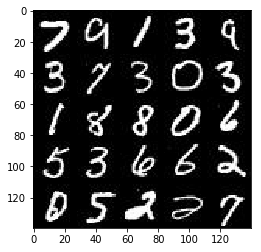

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

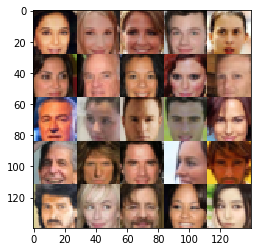

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(input, alpha=0.2, name="leaky_relu"):
    return tf.maximum(input, alpha * input, name=name)

In [7]:
def discriminator(images, reuse=False, keep_prob=0.9):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # convert 28x28x(input_dimension) into 14x14x64
        layer1 = tf.layers.conv2d(images, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer1 = leaky_relu(layer1)
        #layer1 = tf.nn.dropout(layer1, keep_prob=keep_prob)
        #layer1 = tf.Print(layer1, [tf.shape(layer1)], "discriminator layer 1 shape", summarize=100)
        
        # convert 14x14x64 into 7x7x128
        layer2 = tf.layers.conv2d(layer1, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2)
        #layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        #layer2 = tf.Print(layer2, [tf.shape(layer2)], "discriminator layer 2 shape", summarize=100)
        
        # removed a layer as suggested by reviewer
        # convert 7x7x128 into 4x4x256
        layer3 = tf.layers.conv2d(layer2, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3)
        #layer3 = tf.maximum(alpha * layer3, layer3)
        #layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        #layer3 = tf.Print(layer3, [tf.shape(layer3)], "discriminator layer 3 shape", summarize=100)
        
        # flatten to linear array
        convolutions_output = tf.reshape(layer2, (-1, 4 * 4 * 256))
        
        logits = tf.layers.dense(convolutions_output, 1) # 1 single output
        output = tf.sigmoid(logits)
        
    return logits, output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):       
        # transform input into a tensor of 4x4x256
        layer1 = tf.layers.dense(z, 4 * 4 * 256)
        layer1 = tf.reshape(layer1, (-1, 4, 4, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1)
        #layer1 = tf.nn.dropout(layer1, keep_prob=keep_prob)
        #layer1 = tf.Print(layer1, [tf.shape(layer1)], "generator layer 1 shape", summarize=100)
        
        # convert 4x4x256 into 8x8x128
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 4, 1, 'valid', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2)
        #layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        #layer2 = tf.Print(layer2, [tf.shape(layer2)], "generator layer 2 shape", summarize=100)

        # convert 8x8x128 into 16x16x64
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3)
        #layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        #layer3 = tf.Print(layer3, [tf.shape(layer3)], "generator layer 3 shape", summarize=100)

        # convert 16x16x64 into 32x32x(out_channel_dim)
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer(True))
        #layer4 = tf.Print(logits, [tf.shape(logits)], "generator logits shape", summarize=100)
        output = tf.tanh(logits)    
    
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_network = generator(input_z, out_channel_dim, is_train=True)
    
    discriminator_real_network, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_network, discriminator_fake_logits = discriminator(generator_network, reuse=True)
    
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_real_logits,
        labels=tf.ones_like(discriminator_real_network) * 0.9 # smooth real labels
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_fake_logits,
        labels=tf.zeros_like(discriminator_fake_network)
    ))
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_fake_logits,
        labels=tf.ones_like(discriminator_fake_network)
    ))
    
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss

    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_variables = tf.trainable_variables()
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    
    # choo chooo
    discriminator_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        generator_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
   
    return discriminator_train, generator_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, learning_rate_tensor = model_inputs(image_width, image_height, image_channels, z_dim)
    
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels)
    
    discriminator_training, generator_training = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            iterations = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2.0 # normalize to -1, 1
                iterations += 1
                                
                #batch_z_input = np.random.normal(0, scale=1.0, size=(batch_size, z_dim))
                batch_z_input = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                network_feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z_input,
                    learning_rate_tensor: learning_rate
                }
                
                _ = sess.run(discriminator_training, feed_dict=network_feed_dict)
                _ = sess.run(generator_training, feed_dict=network_feed_dict)
                
                if iterations % 10 == 0:
                    training_loss_discriminator = discriminator_loss.eval(network_feed_dict)
                    training_loss_generator = generator_loss.eval(network_feed_dict)
                    
                    print("Iteration {:3} -- Epoch {}/{} -- Discriminator loss: {:5.5f} -- Generator loss: {:5.5f}".format(
                        iterations,
                        epoch_i + 1,
                        epoch_count,
                        training_loss_discriminator,
                        training_loss_generator
                    ))
                
                if iterations % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
        
        show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                    
    print("Done!")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Iteration  10 -- Epoch 1/2 -- Discriminator loss: 1.49406 -- Generator loss: 0.53327
Iteration  20 -- Epoch 1/2 -- Discriminator loss: 1.41183 -- Generator loss: 0.60039
Iteration  30 -- Epoch 1/2 -- Discriminator loss: 1.40485 -- Generator loss: 0.62734
Iteration  40 -- Epoch 1/2 -- Discriminator loss: 1.39558 -- Generator loss: 0.63465
Iteration  50 -- Epoch 1/2 -- Discriminator loss: 1.39671 -- Generator loss: 0.65352
Iteration  60 -- Epoch 1/2 -- Discriminator loss: 1.38990 -- Generator loss: 0.66076
Iteration  70 -- Epoch 1/2 -- Discriminator loss: 1.38148 -- Generator loss: 0.66226
Iteration  80 -- Epoch 1/2 -- Discriminator loss: 1.38689 -- Generator loss: 0.66204
Iteration  90 -- Epoch 1/2 -- Discriminator loss: 1.38035 -- Generator loss: 0.65731
Iteration 100 -- Epoch 1/2 -- Discriminator loss: 1.37422 -- Generator loss: 0.66275


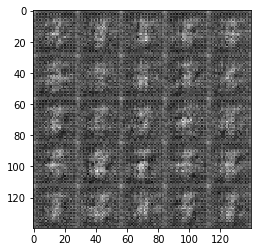

Iteration 110 -- Epoch 1/2 -- Discriminator loss: 1.37601 -- Generator loss: 0.67547
Iteration 120 -- Epoch 1/2 -- Discriminator loss: 1.39204 -- Generator loss: 0.66191
Iteration 130 -- Epoch 1/2 -- Discriminator loss: 1.36946 -- Generator loss: 0.66353
Iteration 140 -- Epoch 1/2 -- Discriminator loss: 1.38360 -- Generator loss: 0.66287
Iteration 150 -- Epoch 1/2 -- Discriminator loss: 1.38108 -- Generator loss: 0.65801
Iteration 160 -- Epoch 1/2 -- Discriminator loss: 1.36951 -- Generator loss: 0.66609
Iteration 170 -- Epoch 1/2 -- Discriminator loss: 1.37159 -- Generator loss: 0.66823
Iteration 180 -- Epoch 1/2 -- Discriminator loss: 1.37134 -- Generator loss: 0.66600
Iteration 190 -- Epoch 1/2 -- Discriminator loss: 1.36338 -- Generator loss: 0.66246
Iteration 200 -- Epoch 1/2 -- Discriminator loss: 1.36214 -- Generator loss: 0.66142


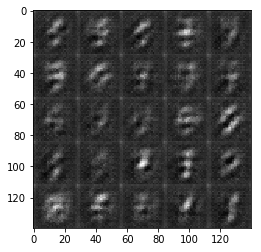

Iteration 210 -- Epoch 1/2 -- Discriminator loss: 1.35984 -- Generator loss: 0.65709
Iteration 220 -- Epoch 1/2 -- Discriminator loss: 1.36069 -- Generator loss: 0.66477
Iteration 230 -- Epoch 1/2 -- Discriminator loss: 1.36340 -- Generator loss: 0.66588
Iteration 240 -- Epoch 1/2 -- Discriminator loss: 1.36488 -- Generator loss: 0.66578
Iteration 250 -- Epoch 1/2 -- Discriminator loss: 1.36611 -- Generator loss: 0.66439
Iteration 260 -- Epoch 1/2 -- Discriminator loss: 1.36881 -- Generator loss: 0.66695
Iteration 270 -- Epoch 1/2 -- Discriminator loss: 1.36132 -- Generator loss: 0.66520
Iteration 280 -- Epoch 1/2 -- Discriminator loss: 1.34311 -- Generator loss: 0.66620
Iteration 290 -- Epoch 1/2 -- Discriminator loss: 1.35379 -- Generator loss: 0.66063
Iteration 300 -- Epoch 1/2 -- Discriminator loss: 1.35807 -- Generator loss: 0.66679


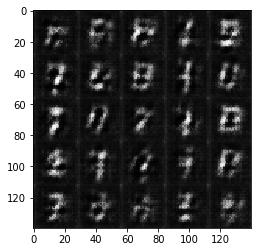

Iteration 310 -- Epoch 1/2 -- Discriminator loss: 1.34662 -- Generator loss: 0.66124
Iteration 320 -- Epoch 1/2 -- Discriminator loss: 1.35682 -- Generator loss: 0.65842
Iteration 330 -- Epoch 1/2 -- Discriminator loss: 1.39221 -- Generator loss: 0.64739
Iteration 340 -- Epoch 1/2 -- Discriminator loss: 1.37790 -- Generator loss: 0.65084
Iteration 350 -- Epoch 1/2 -- Discriminator loss: 1.38078 -- Generator loss: 0.66123
Iteration 360 -- Epoch 1/2 -- Discriminator loss: 1.36679 -- Generator loss: 0.65294
Iteration 370 -- Epoch 1/2 -- Discriminator loss: 1.37028 -- Generator loss: 0.66977
Iteration 380 -- Epoch 1/2 -- Discriminator loss: 1.36882 -- Generator loss: 0.66367
Iteration 390 -- Epoch 1/2 -- Discriminator loss: 1.36543 -- Generator loss: 0.66789
Iteration 400 -- Epoch 1/2 -- Discriminator loss: 1.37252 -- Generator loss: 0.66629


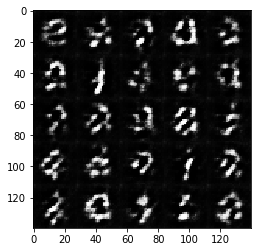

Iteration 410 -- Epoch 1/2 -- Discriminator loss: 1.36325 -- Generator loss: 0.66693
Iteration 420 -- Epoch 1/2 -- Discriminator loss: 1.38840 -- Generator loss: 0.64371
Iteration 430 -- Epoch 1/2 -- Discriminator loss: 1.37635 -- Generator loss: 0.64441
Iteration 440 -- Epoch 1/2 -- Discriminator loss: 1.36826 -- Generator loss: 0.65783
Iteration 450 -- Epoch 1/2 -- Discriminator loss: 1.36981 -- Generator loss: 0.65855
Iteration 460 -- Epoch 1/2 -- Discriminator loss: 1.36504 -- Generator loss: 0.66282
Iteration 470 -- Epoch 1/2 -- Discriminator loss: 1.37107 -- Generator loss: 0.67654
Iteration 480 -- Epoch 1/2 -- Discriminator loss: 1.36560 -- Generator loss: 0.66191
Iteration 490 -- Epoch 1/2 -- Discriminator loss: 1.37337 -- Generator loss: 0.65951
Iteration 500 -- Epoch 1/2 -- Discriminator loss: 1.37641 -- Generator loss: 0.65625


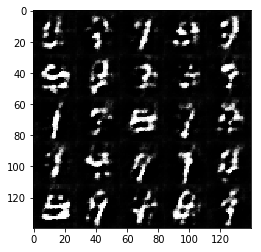

Iteration 510 -- Epoch 1/2 -- Discriminator loss: 1.37446 -- Generator loss: 0.65268
Iteration 520 -- Epoch 1/2 -- Discriminator loss: 1.36380 -- Generator loss: 0.66138
Iteration 530 -- Epoch 1/2 -- Discriminator loss: 1.37567 -- Generator loss: 0.65184
Iteration 540 -- Epoch 1/2 -- Discriminator loss: 1.37776 -- Generator loss: 0.66630
Iteration 550 -- Epoch 1/2 -- Discriminator loss: 1.37137 -- Generator loss: 0.64537
Iteration 560 -- Epoch 1/2 -- Discriminator loss: 1.36949 -- Generator loss: 0.67662
Iteration 570 -- Epoch 1/2 -- Discriminator loss: 1.36481 -- Generator loss: 0.66396
Iteration 580 -- Epoch 1/2 -- Discriminator loss: 1.37091 -- Generator loss: 0.66140
Iteration 590 -- Epoch 1/2 -- Discriminator loss: 1.36566 -- Generator loss: 0.66276
Iteration 600 -- Epoch 1/2 -- Discriminator loss: 1.37510 -- Generator loss: 0.65578


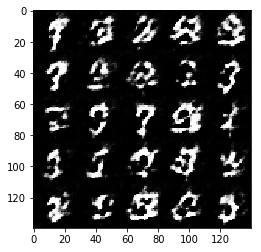

Iteration 610 -- Epoch 1/2 -- Discriminator loss: 1.37096 -- Generator loss: 0.65401
Iteration 620 -- Epoch 1/2 -- Discriminator loss: 1.36943 -- Generator loss: 0.65220
Iteration 630 -- Epoch 1/2 -- Discriminator loss: 1.37897 -- Generator loss: 0.65882
Iteration 640 -- Epoch 1/2 -- Discriminator loss: 1.36590 -- Generator loss: 0.66213
Iteration 650 -- Epoch 1/2 -- Discriminator loss: 1.37912 -- Generator loss: 0.65585
Iteration 660 -- Epoch 1/2 -- Discriminator loss: 1.36815 -- Generator loss: 0.65370
Iteration 670 -- Epoch 1/2 -- Discriminator loss: 1.36493 -- Generator loss: 0.66238
Iteration 680 -- Epoch 1/2 -- Discriminator loss: 1.37017 -- Generator loss: 0.65789
Iteration 690 -- Epoch 1/2 -- Discriminator loss: 1.37836 -- Generator loss: 0.66019
Iteration 700 -- Epoch 1/2 -- Discriminator loss: 1.37697 -- Generator loss: 0.65255


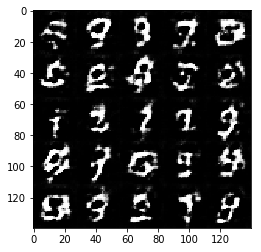

Iteration 710 -- Epoch 1/2 -- Discriminator loss: 1.37949 -- Generator loss: 0.65715
Iteration 720 -- Epoch 1/2 -- Discriminator loss: 1.37272 -- Generator loss: 0.66632
Iteration 730 -- Epoch 1/2 -- Discriminator loss: 1.38274 -- Generator loss: 0.64531
Iteration 740 -- Epoch 1/2 -- Discriminator loss: 1.37086 -- Generator loss: 0.64989
Iteration 750 -- Epoch 1/2 -- Discriminator loss: 1.37694 -- Generator loss: 0.64999
Iteration 760 -- Epoch 1/2 -- Discriminator loss: 1.37796 -- Generator loss: 0.64293
Iteration 770 -- Epoch 1/2 -- Discriminator loss: 1.38321 -- Generator loss: 0.65507
Iteration 780 -- Epoch 1/2 -- Discriminator loss: 1.37870 -- Generator loss: 0.65869
Iteration 790 -- Epoch 1/2 -- Discriminator loss: 1.37942 -- Generator loss: 0.66168
Iteration 800 -- Epoch 1/2 -- Discriminator loss: 1.37840 -- Generator loss: 0.66533


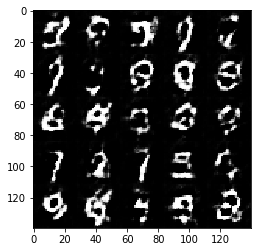

Iteration 810 -- Epoch 1/2 -- Discriminator loss: 1.37507 -- Generator loss: 0.65634
Iteration 820 -- Epoch 1/2 -- Discriminator loss: 1.38242 -- Generator loss: 0.65277
Iteration 830 -- Epoch 1/2 -- Discriminator loss: 1.37558 -- Generator loss: 0.64894
Iteration 840 -- Epoch 1/2 -- Discriminator loss: 1.38469 -- Generator loss: 0.66445
Iteration 850 -- Epoch 1/2 -- Discriminator loss: 1.37776 -- Generator loss: 0.66411
Iteration 860 -- Epoch 1/2 -- Discriminator loss: 1.38281 -- Generator loss: 0.65188
Iteration 870 -- Epoch 1/2 -- Discriminator loss: 1.37862 -- Generator loss: 0.65542
Iteration 880 -- Epoch 1/2 -- Discriminator loss: 1.37978 -- Generator loss: 0.65727
Iteration 890 -- Epoch 1/2 -- Discriminator loss: 1.36783 -- Generator loss: 0.65369
Iteration 900 -- Epoch 1/2 -- Discriminator loss: 1.37503 -- Generator loss: 0.64617


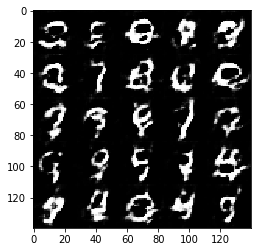

Iteration 910 -- Epoch 1/2 -- Discriminator loss: 1.38052 -- Generator loss: 0.65787
Iteration 920 -- Epoch 1/2 -- Discriminator loss: 1.37869 -- Generator loss: 0.64722
Iteration 930 -- Epoch 1/2 -- Discriminator loss: 1.36779 -- Generator loss: 0.65876
Iteration  10 -- Epoch 2/2 -- Discriminator loss: 1.38041 -- Generator loss: 0.64901
Iteration  20 -- Epoch 2/2 -- Discriminator loss: 1.36632 -- Generator loss: 0.66462
Iteration  30 -- Epoch 2/2 -- Discriminator loss: 1.37622 -- Generator loss: 0.66340
Iteration  40 -- Epoch 2/2 -- Discriminator loss: 1.37230 -- Generator loss: 0.65485
Iteration  50 -- Epoch 2/2 -- Discriminator loss: 1.37740 -- Generator loss: 0.67327
Iteration  60 -- Epoch 2/2 -- Discriminator loss: 1.36974 -- Generator loss: 0.67467
Iteration  70 -- Epoch 2/2 -- Discriminator loss: 1.36927 -- Generator loss: 0.66660
Iteration  80 -- Epoch 2/2 -- Discriminator loss: 1.36256 -- Generator loss: 0.65913
Iteration  90 -- Epoch 2/2 -- Discriminator loss: 1.37550 -- Gene

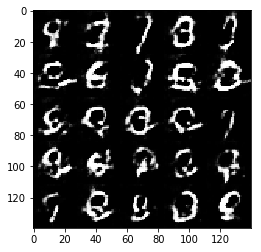

Iteration 110 -- Epoch 2/2 -- Discriminator loss: 1.39438 -- Generator loss: 0.65282
Iteration 120 -- Epoch 2/2 -- Discriminator loss: 1.37653 -- Generator loss: 0.64456
Iteration 130 -- Epoch 2/2 -- Discriminator loss: 1.38077 -- Generator loss: 0.66933
Iteration 140 -- Epoch 2/2 -- Discriminator loss: 1.38291 -- Generator loss: 0.65916
Iteration 150 -- Epoch 2/2 -- Discriminator loss: 1.36375 -- Generator loss: 0.66532
Iteration 160 -- Epoch 2/2 -- Discriminator loss: 1.37523 -- Generator loss: 0.66558
Iteration 170 -- Epoch 2/2 -- Discriminator loss: 1.37821 -- Generator loss: 0.65200
Iteration 180 -- Epoch 2/2 -- Discriminator loss: 1.37769 -- Generator loss: 0.66739
Iteration 190 -- Epoch 2/2 -- Discriminator loss: 1.38169 -- Generator loss: 0.65740
Iteration 200 -- Epoch 2/2 -- Discriminator loss: 1.38232 -- Generator loss: 0.65991


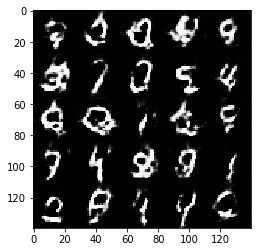

Iteration 210 -- Epoch 2/2 -- Discriminator loss: 1.35996 -- Generator loss: 0.66547
Iteration 220 -- Epoch 2/2 -- Discriminator loss: 1.37690 -- Generator loss: 0.66720
Iteration 230 -- Epoch 2/2 -- Discriminator loss: 1.37850 -- Generator loss: 0.64915
Iteration 240 -- Epoch 2/2 -- Discriminator loss: 1.38891 -- Generator loss: 0.65640
Iteration 250 -- Epoch 2/2 -- Discriminator loss: 1.39062 -- Generator loss: 0.66178
Iteration 260 -- Epoch 2/2 -- Discriminator loss: 1.37938 -- Generator loss: 0.67267
Iteration 270 -- Epoch 2/2 -- Discriminator loss: 1.38111 -- Generator loss: 0.66096
Iteration 280 -- Epoch 2/2 -- Discriminator loss: 1.38243 -- Generator loss: 0.65928
Iteration 290 -- Epoch 2/2 -- Discriminator loss: 1.37663 -- Generator loss: 0.65826
Iteration 300 -- Epoch 2/2 -- Discriminator loss: 1.38177 -- Generator loss: 0.66911


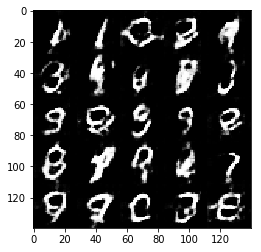

Iteration 310 -- Epoch 2/2 -- Discriminator loss: 1.36855 -- Generator loss: 0.67581
Iteration 320 -- Epoch 2/2 -- Discriminator loss: 1.36771 -- Generator loss: 0.66124
Iteration 330 -- Epoch 2/2 -- Discriminator loss: 1.37353 -- Generator loss: 0.66605
Iteration 340 -- Epoch 2/2 -- Discriminator loss: 1.38160 -- Generator loss: 0.66426
Iteration 350 -- Epoch 2/2 -- Discriminator loss: 1.37789 -- Generator loss: 0.66006
Iteration 360 -- Epoch 2/2 -- Discriminator loss: 1.38129 -- Generator loss: 0.65441
Iteration 370 -- Epoch 2/2 -- Discriminator loss: 1.39422 -- Generator loss: 0.66610
Iteration 380 -- Epoch 2/2 -- Discriminator loss: 1.38747 -- Generator loss: 0.67008
Iteration 390 -- Epoch 2/2 -- Discriminator loss: 1.38172 -- Generator loss: 0.66062
Iteration 400 -- Epoch 2/2 -- Discriminator loss: 1.37947 -- Generator loss: 0.66055


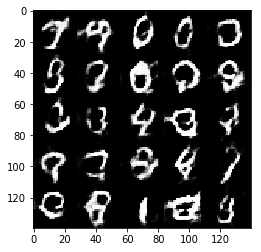

Iteration 410 -- Epoch 2/2 -- Discriminator loss: 1.38437 -- Generator loss: 0.65776
Iteration 420 -- Epoch 2/2 -- Discriminator loss: 1.37906 -- Generator loss: 0.66820
Iteration 430 -- Epoch 2/2 -- Discriminator loss: 1.37124 -- Generator loss: 0.66141
Iteration 440 -- Epoch 2/2 -- Discriminator loss: 1.37486 -- Generator loss: 0.65754
Iteration 450 -- Epoch 2/2 -- Discriminator loss: 1.37750 -- Generator loss: 0.66035
Iteration 460 -- Epoch 2/2 -- Discriminator loss: 1.38407 -- Generator loss: 0.65515
Iteration 470 -- Epoch 2/2 -- Discriminator loss: 1.37095 -- Generator loss: 0.67082
Iteration 480 -- Epoch 2/2 -- Discriminator loss: 1.38100 -- Generator loss: 0.65101
Iteration 490 -- Epoch 2/2 -- Discriminator loss: 1.37115 -- Generator loss: 0.67341
Iteration 500 -- Epoch 2/2 -- Discriminator loss: 1.38195 -- Generator loss: 0.65977


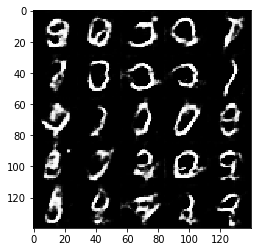

Iteration 510 -- Epoch 2/2 -- Discriminator loss: 1.37001 -- Generator loss: 0.66375
Iteration 520 -- Epoch 2/2 -- Discriminator loss: 1.38497 -- Generator loss: 0.65633
Iteration 530 -- Epoch 2/2 -- Discriminator loss: 1.37383 -- Generator loss: 0.65780
Iteration 540 -- Epoch 2/2 -- Discriminator loss: 1.38214 -- Generator loss: 0.66265
Iteration 550 -- Epoch 2/2 -- Discriminator loss: 1.38205 -- Generator loss: 0.65582
Iteration 560 -- Epoch 2/2 -- Discriminator loss: 1.37785 -- Generator loss: 0.66576
Iteration 570 -- Epoch 2/2 -- Discriminator loss: 1.39917 -- Generator loss: 0.64841
Iteration 580 -- Epoch 2/2 -- Discriminator loss: 1.37042 -- Generator loss: 0.67963
Iteration 590 -- Epoch 2/2 -- Discriminator loss: 1.37307 -- Generator loss: 0.67502
Iteration 600 -- Epoch 2/2 -- Discriminator loss: 1.37923 -- Generator loss: 0.67245


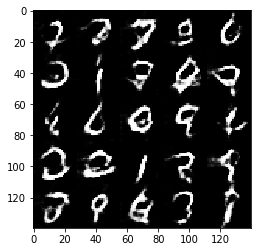

Iteration 610 -- Epoch 2/2 -- Discriminator loss: 1.38567 -- Generator loss: 0.65250
Iteration 620 -- Epoch 2/2 -- Discriminator loss: 1.38400 -- Generator loss: 0.67406
Iteration 630 -- Epoch 2/2 -- Discriminator loss: 1.39008 -- Generator loss: 0.67617
Iteration 640 -- Epoch 2/2 -- Discriminator loss: 1.38559 -- Generator loss: 0.66520
Iteration 650 -- Epoch 2/2 -- Discriminator loss: 1.38001 -- Generator loss: 0.67564
Iteration 660 -- Epoch 2/2 -- Discriminator loss: 1.37820 -- Generator loss: 0.67251
Iteration 670 -- Epoch 2/2 -- Discriminator loss: 1.37296 -- Generator loss: 0.67660
Iteration 680 -- Epoch 2/2 -- Discriminator loss: 1.36913 -- Generator loss: 0.68000
Iteration 690 -- Epoch 2/2 -- Discriminator loss: 1.38109 -- Generator loss: 0.67211
Iteration 700 -- Epoch 2/2 -- Discriminator loss: 1.38822 -- Generator loss: 0.65463


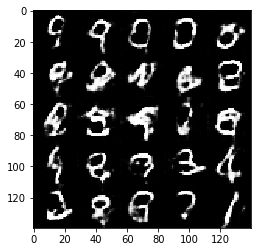

Iteration 710 -- Epoch 2/2 -- Discriminator loss: 1.37365 -- Generator loss: 0.66203
Iteration 720 -- Epoch 2/2 -- Discriminator loss: 1.39271 -- Generator loss: 0.66679
Iteration 730 -- Epoch 2/2 -- Discriminator loss: 1.38900 -- Generator loss: 0.66664
Iteration 740 -- Epoch 2/2 -- Discriminator loss: 1.37697 -- Generator loss: 0.66816
Iteration 750 -- Epoch 2/2 -- Discriminator loss: 1.38236 -- Generator loss: 0.65646
Iteration 760 -- Epoch 2/2 -- Discriminator loss: 1.38646 -- Generator loss: 0.66936
Iteration 770 -- Epoch 2/2 -- Discriminator loss: 1.38673 -- Generator loss: 0.66431
Iteration 780 -- Epoch 2/2 -- Discriminator loss: 1.39124 -- Generator loss: 0.66247
Iteration 790 -- Epoch 2/2 -- Discriminator loss: 1.38600 -- Generator loss: 0.66886
Iteration 800 -- Epoch 2/2 -- Discriminator loss: 1.37275 -- Generator loss: 0.66353


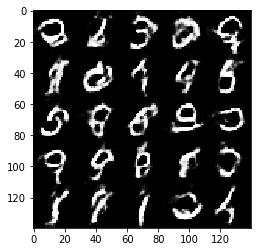

Iteration 810 -- Epoch 2/2 -- Discriminator loss: 1.38367 -- Generator loss: 0.68082
Iteration 820 -- Epoch 2/2 -- Discriminator loss: 1.38756 -- Generator loss: 0.66790
Iteration 830 -- Epoch 2/2 -- Discriminator loss: 1.38212 -- Generator loss: 0.67807
Iteration 840 -- Epoch 2/2 -- Discriminator loss: 1.38296 -- Generator loss: 0.67275
Iteration 850 -- Epoch 2/2 -- Discriminator loss: 1.38484 -- Generator loss: 0.67097
Iteration 860 -- Epoch 2/2 -- Discriminator loss: 1.38815 -- Generator loss: 0.67199
Iteration 870 -- Epoch 2/2 -- Discriminator loss: 1.38561 -- Generator loss: 0.67457
Iteration 880 -- Epoch 2/2 -- Discriminator loss: 1.37928 -- Generator loss: 0.67809
Iteration 890 -- Epoch 2/2 -- Discriminator loss: 1.37904 -- Generator loss: 0.67248
Iteration 900 -- Epoch 2/2 -- Discriminator loss: 1.37570 -- Generator loss: 0.67661


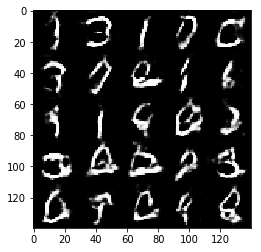

Iteration 910 -- Epoch 2/2 -- Discriminator loss: 1.38636 -- Generator loss: 0.66240
Iteration 920 -- Epoch 2/2 -- Discriminator loss: 1.38243 -- Generator loss: 0.65363
Iteration 930 -- Epoch 2/2 -- Discriminator loss: 1.38378 -- Generator loss: 0.65989


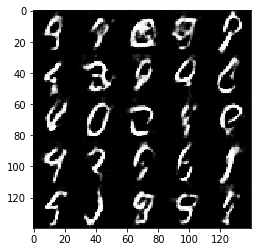

Done!


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Iteration  10 -- Epoch 1/1 -- Discriminator loss: 1.52326 -- Generator loss: 0.52265
Iteration  20 -- Epoch 1/1 -- Discriminator loss: 1.39052 -- Generator loss: 0.61177
Iteration  30 -- Epoch 1/1 -- Discriminator loss: 1.35005 -- Generator loss: 0.63169
Iteration  40 -- Epoch 1/1 -- Discriminator loss: 1.34553 -- Generator loss: 0.64501
Iteration  50 -- Epoch 1/1 -- Discriminator loss: 1.31878 -- Generator loss: 0.65214
Iteration  60 -- Epoch 1/1 -- Discriminator loss: 1.35357 -- Generator loss: 0.64057
Iteration  70 -- Epoch 1/1 -- Discriminator loss: 1.37064 -- Generator loss: 0.64581
Iteration  80 -- Epoch 1/1 -- Discriminator loss: 1.37834 -- Generator loss: 0.64680
Iteration  90 -- Epoch 1/1 -- Discriminator loss: 1.34896 -- Generator loss: 0.65379
Iteration 100 -- Epoch 1/1 -- Discriminator loss: 1.34780 -- Generator loss: 0.65107


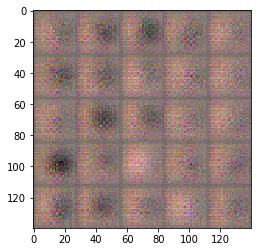

Iteration 110 -- Epoch 1/1 -- Discriminator loss: 1.33193 -- Generator loss: 0.66272
Iteration 120 -- Epoch 1/1 -- Discriminator loss: 1.32549 -- Generator loss: 0.65169
Iteration 130 -- Epoch 1/1 -- Discriminator loss: 1.33970 -- Generator loss: 0.64809
Iteration 140 -- Epoch 1/1 -- Discriminator loss: 1.35067 -- Generator loss: 0.65219
Iteration 150 -- Epoch 1/1 -- Discriminator loss: 1.33119 -- Generator loss: 0.66293
Iteration 160 -- Epoch 1/1 -- Discriminator loss: 1.34318 -- Generator loss: 0.66608
Iteration 170 -- Epoch 1/1 -- Discriminator loss: 1.35450 -- Generator loss: 0.66391
Iteration 180 -- Epoch 1/1 -- Discriminator loss: 1.35001 -- Generator loss: 0.65713
Iteration 190 -- Epoch 1/1 -- Discriminator loss: 1.34316 -- Generator loss: 0.66566
Iteration 200 -- Epoch 1/1 -- Discriminator loss: 1.33596 -- Generator loss: 0.64692


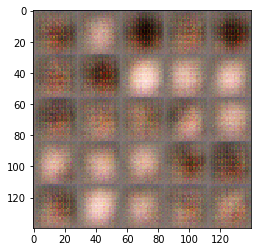

Iteration 210 -- Epoch 1/1 -- Discriminator loss: 1.34595 -- Generator loss: 0.67035
Iteration 220 -- Epoch 1/1 -- Discriminator loss: 1.34625 -- Generator loss: 0.65450
Iteration 230 -- Epoch 1/1 -- Discriminator loss: 1.32780 -- Generator loss: 0.66737
Iteration 240 -- Epoch 1/1 -- Discriminator loss: 1.33007 -- Generator loss: 0.66645
Iteration 250 -- Epoch 1/1 -- Discriminator loss: 1.34127 -- Generator loss: 0.65824
Iteration 260 -- Epoch 1/1 -- Discriminator loss: 1.34096 -- Generator loss: 0.64525
Iteration 270 -- Epoch 1/1 -- Discriminator loss: 1.34560 -- Generator loss: 0.64138
Iteration 280 -- Epoch 1/1 -- Discriminator loss: 1.34706 -- Generator loss: 0.64158
Iteration 290 -- Epoch 1/1 -- Discriminator loss: 1.33367 -- Generator loss: 0.66769
Iteration 300 -- Epoch 1/1 -- Discriminator loss: 1.34459 -- Generator loss: 0.65191


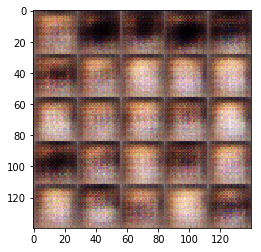

Iteration 310 -- Epoch 1/1 -- Discriminator loss: 1.36671 -- Generator loss: 0.64817
Iteration 320 -- Epoch 1/1 -- Discriminator loss: 1.37614 -- Generator loss: 0.63788
Iteration 330 -- Epoch 1/1 -- Discriminator loss: 1.39768 -- Generator loss: 0.64661
Iteration 340 -- Epoch 1/1 -- Discriminator loss: 1.42157 -- Generator loss: 0.62687
Iteration 350 -- Epoch 1/1 -- Discriminator loss: 1.41863 -- Generator loss: 0.63878
Iteration 360 -- Epoch 1/1 -- Discriminator loss: 1.37916 -- Generator loss: 0.65678
Iteration 370 -- Epoch 1/1 -- Discriminator loss: 1.40563 -- Generator loss: 0.64125
Iteration 380 -- Epoch 1/1 -- Discriminator loss: 1.37548 -- Generator loss: 0.66811
Iteration 390 -- Epoch 1/1 -- Discriminator loss: 1.39825 -- Generator loss: 0.65655
Iteration 400 -- Epoch 1/1 -- Discriminator loss: 1.39016 -- Generator loss: 0.67686


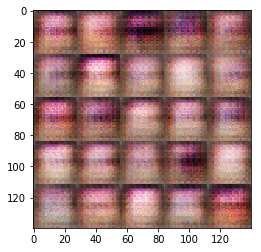

Iteration 410 -- Epoch 1/1 -- Discriminator loss: 1.36026 -- Generator loss: 0.67268
Iteration 420 -- Epoch 1/1 -- Discriminator loss: 1.38521 -- Generator loss: 0.67054
Iteration 430 -- Epoch 1/1 -- Discriminator loss: 1.38367 -- Generator loss: 0.65731
Iteration 440 -- Epoch 1/1 -- Discriminator loss: 1.40025 -- Generator loss: 0.64658
Iteration 450 -- Epoch 1/1 -- Discriminator loss: 1.39321 -- Generator loss: 0.66036
Iteration 460 -- Epoch 1/1 -- Discriminator loss: 1.39646 -- Generator loss: 0.66885
Iteration 470 -- Epoch 1/1 -- Discriminator loss: 1.39622 -- Generator loss: 0.64953
Iteration 480 -- Epoch 1/1 -- Discriminator loss: 1.38433 -- Generator loss: 0.66897
Iteration 490 -- Epoch 1/1 -- Discriminator loss: 1.39872 -- Generator loss: 0.66854
Iteration 500 -- Epoch 1/1 -- Discriminator loss: 1.37677 -- Generator loss: 0.67302


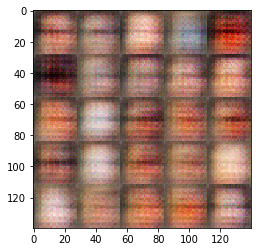

Iteration 510 -- Epoch 1/1 -- Discriminator loss: 1.37208 -- Generator loss: 0.67398
Iteration 520 -- Epoch 1/1 -- Discriminator loss: 1.38354 -- Generator loss: 0.66235
Iteration 530 -- Epoch 1/1 -- Discriminator loss: 1.36902 -- Generator loss: 0.66271
Iteration 540 -- Epoch 1/1 -- Discriminator loss: 1.38171 -- Generator loss: 0.65847
Iteration 550 -- Epoch 1/1 -- Discriminator loss: 1.36607 -- Generator loss: 0.66430
Iteration 560 -- Epoch 1/1 -- Discriminator loss: 1.34059 -- Generator loss: 0.66790
Iteration 570 -- Epoch 1/1 -- Discriminator loss: 1.37324 -- Generator loss: 0.66744
Iteration 580 -- Epoch 1/1 -- Discriminator loss: 1.37496 -- Generator loss: 0.65638
Iteration 590 -- Epoch 1/1 -- Discriminator loss: 1.37129 -- Generator loss: 0.65602
Iteration 600 -- Epoch 1/1 -- Discriminator loss: 1.36779 -- Generator loss: 0.66006


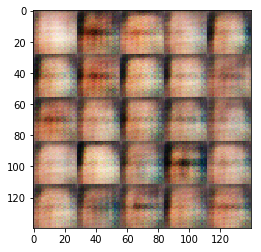

Iteration 610 -- Epoch 1/1 -- Discriminator loss: 1.33472 -- Generator loss: 0.65942
Iteration 620 -- Epoch 1/1 -- Discriminator loss: 1.34920 -- Generator loss: 0.66743
Iteration 630 -- Epoch 1/1 -- Discriminator loss: 1.36728 -- Generator loss: 0.65405
Iteration 640 -- Epoch 1/1 -- Discriminator loss: 1.34260 -- Generator loss: 0.66468
Iteration 650 -- Epoch 1/1 -- Discriminator loss: 1.33669 -- Generator loss: 0.66777
Iteration 660 -- Epoch 1/1 -- Discriminator loss: 1.39573 -- Generator loss: 0.63122
Iteration 670 -- Epoch 1/1 -- Discriminator loss: 1.34987 -- Generator loss: 0.65955
Iteration 680 -- Epoch 1/1 -- Discriminator loss: 1.33487 -- Generator loss: 0.63864
Iteration 690 -- Epoch 1/1 -- Discriminator loss: 1.35123 -- Generator loss: 0.64848
Iteration 700 -- Epoch 1/1 -- Discriminator loss: 1.31465 -- Generator loss: 0.65045


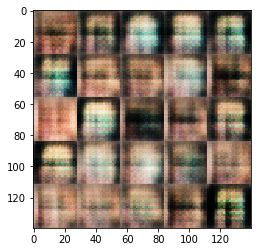

Iteration 710 -- Epoch 1/1 -- Discriminator loss: 1.36416 -- Generator loss: 0.62969
Iteration 720 -- Epoch 1/1 -- Discriminator loss: 1.33897 -- Generator loss: 0.64905
Iteration 730 -- Epoch 1/1 -- Discriminator loss: 1.31803 -- Generator loss: 0.64622
Iteration 740 -- Epoch 1/1 -- Discriminator loss: 1.33867 -- Generator loss: 0.62362
Iteration 750 -- Epoch 1/1 -- Discriminator loss: 1.31421 -- Generator loss: 0.63433
Iteration 760 -- Epoch 1/1 -- Discriminator loss: 1.33128 -- Generator loss: 0.63167
Iteration 770 -- Epoch 1/1 -- Discriminator loss: 1.33926 -- Generator loss: 0.64070
Iteration 780 -- Epoch 1/1 -- Discriminator loss: 1.34277 -- Generator loss: 0.64218
Iteration 790 -- Epoch 1/1 -- Discriminator loss: 1.31768 -- Generator loss: 0.64059
Iteration 800 -- Epoch 1/1 -- Discriminator loss: 1.34202 -- Generator loss: 0.63246


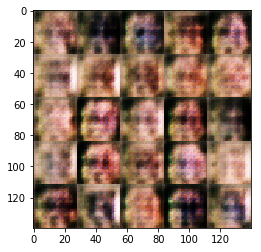

Iteration 810 -- Epoch 1/1 -- Discriminator loss: 1.34399 -- Generator loss: 0.63154
Iteration 820 -- Epoch 1/1 -- Discriminator loss: 1.31804 -- Generator loss: 0.64670
Iteration 830 -- Epoch 1/1 -- Discriminator loss: 1.29775 -- Generator loss: 0.65474
Iteration 840 -- Epoch 1/1 -- Discriminator loss: 1.34265 -- Generator loss: 0.62262
Iteration 850 -- Epoch 1/1 -- Discriminator loss: 1.32401 -- Generator loss: 0.63162
Iteration 860 -- Epoch 1/1 -- Discriminator loss: 1.31149 -- Generator loss: 0.64096
Iteration 870 -- Epoch 1/1 -- Discriminator loss: 1.29496 -- Generator loss: 0.65529
Iteration 880 -- Epoch 1/1 -- Discriminator loss: 1.32217 -- Generator loss: 0.63158
Iteration 890 -- Epoch 1/1 -- Discriminator loss: 1.31581 -- Generator loss: 0.63218
Iteration 900 -- Epoch 1/1 -- Discriminator loss: 1.35749 -- Generator loss: 0.59122


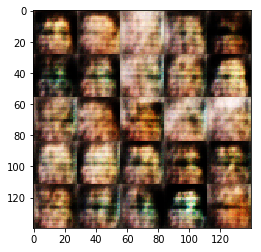

Iteration 910 -- Epoch 1/1 -- Discriminator loss: 1.29407 -- Generator loss: 0.64617
Iteration 920 -- Epoch 1/1 -- Discriminator loss: 1.30739 -- Generator loss: 0.64216
Iteration 930 -- Epoch 1/1 -- Discriminator loss: 1.35358 -- Generator loss: 0.61677
Iteration 940 -- Epoch 1/1 -- Discriminator loss: 1.25036 -- Generator loss: 0.65008
Iteration 950 -- Epoch 1/1 -- Discriminator loss: 1.26874 -- Generator loss: 0.65318
Iteration 960 -- Epoch 1/1 -- Discriminator loss: 1.26278 -- Generator loss: 0.66047
Iteration 970 -- Epoch 1/1 -- Discriminator loss: 1.26576 -- Generator loss: 0.65859
Iteration 980 -- Epoch 1/1 -- Discriminator loss: 1.29572 -- Generator loss: 0.63939
Iteration 990 -- Epoch 1/1 -- Discriminator loss: 1.21721 -- Generator loss: 0.67211
Iteration 1000 -- Epoch 1/1 -- Discriminator loss: 1.32748 -- Generator loss: 0.64135


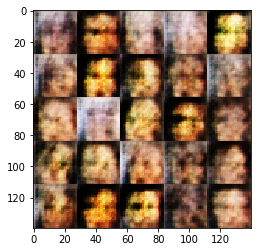

Iteration 1010 -- Epoch 1/1 -- Discriminator loss: 1.23342 -- Generator loss: 0.66023
Iteration 1020 -- Epoch 1/1 -- Discriminator loss: 1.27406 -- Generator loss: 0.64883
Iteration 1030 -- Epoch 1/1 -- Discriminator loss: 1.27330 -- Generator loss: 0.62791
Iteration 1040 -- Epoch 1/1 -- Discriminator loss: 1.24931 -- Generator loss: 0.62636
Iteration 1050 -- Epoch 1/1 -- Discriminator loss: 1.29834 -- Generator loss: 0.62199
Iteration 1060 -- Epoch 1/1 -- Discriminator loss: 1.31073 -- Generator loss: 0.59325
Iteration 1070 -- Epoch 1/1 -- Discriminator loss: 1.32176 -- Generator loss: 0.62782
Iteration 1080 -- Epoch 1/1 -- Discriminator loss: 1.29070 -- Generator loss: 0.62214
Iteration 1090 -- Epoch 1/1 -- Discriminator loss: 1.32837 -- Generator loss: 0.58358
Iteration 1100 -- Epoch 1/1 -- Discriminator loss: 1.19773 -- Generator loss: 0.67684


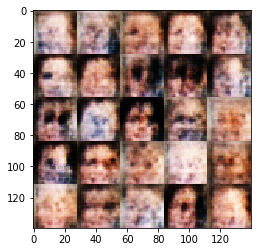

Iteration 1110 -- Epoch 1/1 -- Discriminator loss: 1.26736 -- Generator loss: 0.63730
Iteration 1120 -- Epoch 1/1 -- Discriminator loss: 1.20367 -- Generator loss: 0.64662
Iteration 1130 -- Epoch 1/1 -- Discriminator loss: 1.26179 -- Generator loss: 0.64736
Iteration 1140 -- Epoch 1/1 -- Discriminator loss: 1.25450 -- Generator loss: 0.64311
Iteration 1150 -- Epoch 1/1 -- Discriminator loss: 1.23181 -- Generator loss: 0.65951
Iteration 1160 -- Epoch 1/1 -- Discriminator loss: 1.31788 -- Generator loss: 0.61503
Iteration 1170 -- Epoch 1/1 -- Discriminator loss: 1.27400 -- Generator loss: 0.65301
Iteration 1180 -- Epoch 1/1 -- Discriminator loss: 1.30089 -- Generator loss: 0.62153
Iteration 1190 -- Epoch 1/1 -- Discriminator loss: 1.30782 -- Generator loss: 0.61885
Iteration 1200 -- Epoch 1/1 -- Discriminator loss: 1.24328 -- Generator loss: 0.63959


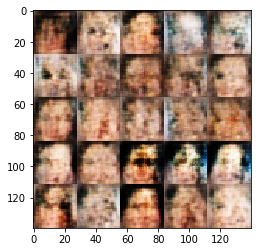

Iteration 1210 -- Epoch 1/1 -- Discriminator loss: 1.25467 -- Generator loss: 0.64142
Iteration 1220 -- Epoch 1/1 -- Discriminator loss: 1.27531 -- Generator loss: 0.63491
Iteration 1230 -- Epoch 1/1 -- Discriminator loss: 1.34583 -- Generator loss: 0.62793
Iteration 1240 -- Epoch 1/1 -- Discriminator loss: 1.29943 -- Generator loss: 0.62631
Iteration 1250 -- Epoch 1/1 -- Discriminator loss: 1.33438 -- Generator loss: 0.59048
Iteration 1260 -- Epoch 1/1 -- Discriminator loss: 1.31447 -- Generator loss: 0.64184
Iteration 1270 -- Epoch 1/1 -- Discriminator loss: 1.30869 -- Generator loss: 0.62910
Iteration 1280 -- Epoch 1/1 -- Discriminator loss: 1.23817 -- Generator loss: 0.64340
Iteration 1290 -- Epoch 1/1 -- Discriminator loss: 1.23889 -- Generator loss: 0.64430
Iteration 1300 -- Epoch 1/1 -- Discriminator loss: 1.29726 -- Generator loss: 0.63210


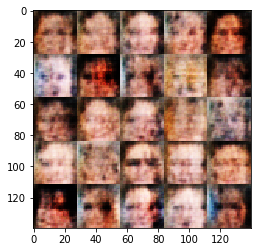

Iteration 1310 -- Epoch 1/1 -- Discriminator loss: 1.31705 -- Generator loss: 0.62926
Iteration 1320 -- Epoch 1/1 -- Discriminator loss: 1.26962 -- Generator loss: 0.64362
Iteration 1330 -- Epoch 1/1 -- Discriminator loss: 1.25903 -- Generator loss: 0.64919
Iteration 1340 -- Epoch 1/1 -- Discriminator loss: 1.30962 -- Generator loss: 0.62448
Iteration 1350 -- Epoch 1/1 -- Discriminator loss: 1.29830 -- Generator loss: 0.62866
Iteration 1360 -- Epoch 1/1 -- Discriminator loss: 1.30530 -- Generator loss: 0.62164
Iteration 1370 -- Epoch 1/1 -- Discriminator loss: 1.31670 -- Generator loss: 0.62422
Iteration 1380 -- Epoch 1/1 -- Discriminator loss: 1.30659 -- Generator loss: 0.63219
Iteration 1390 -- Epoch 1/1 -- Discriminator loss: 1.37115 -- Generator loss: 0.61596
Iteration 1400 -- Epoch 1/1 -- Discriminator loss: 1.27367 -- Generator loss: 0.64497


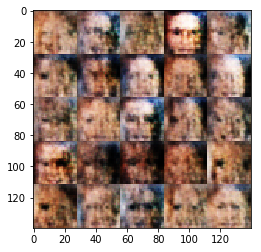

Iteration 1410 -- Epoch 1/1 -- Discriminator loss: 1.20985 -- Generator loss: 0.66618
Iteration 1420 -- Epoch 1/1 -- Discriminator loss: 1.37616 -- Generator loss: 0.60656
Iteration 1430 -- Epoch 1/1 -- Discriminator loss: 1.26295 -- Generator loss: 0.65481
Iteration 1440 -- Epoch 1/1 -- Discriminator loss: 1.32127 -- Generator loss: 0.64446
Iteration 1450 -- Epoch 1/1 -- Discriminator loss: 1.31060 -- Generator loss: 0.63200
Iteration 1460 -- Epoch 1/1 -- Discriminator loss: 1.28698 -- Generator loss: 0.65081
Iteration 1470 -- Epoch 1/1 -- Discriminator loss: 1.32523 -- Generator loss: 0.61352
Iteration 1480 -- Epoch 1/1 -- Discriminator loss: 1.30525 -- Generator loss: 0.62836
Iteration 1490 -- Epoch 1/1 -- Discriminator loss: 1.29021 -- Generator loss: 0.63791
Iteration 1500 -- Epoch 1/1 -- Discriminator loss: 1.31498 -- Generator loss: 0.63244


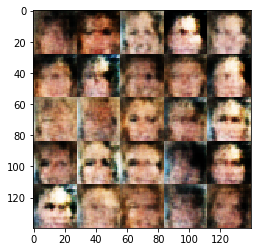

Iteration 1510 -- Epoch 1/1 -- Discriminator loss: 1.31998 -- Generator loss: 0.62088
Iteration 1520 -- Epoch 1/1 -- Discriminator loss: 1.31422 -- Generator loss: 0.60033
Iteration 1530 -- Epoch 1/1 -- Discriminator loss: 1.30720 -- Generator loss: 0.62994
Iteration 1540 -- Epoch 1/1 -- Discriminator loss: 1.30042 -- Generator loss: 0.61264
Iteration 1550 -- Epoch 1/1 -- Discriminator loss: 1.28377 -- Generator loss: 0.62705
Iteration 1560 -- Epoch 1/1 -- Discriminator loss: 1.27590 -- Generator loss: 0.63392
Iteration 1570 -- Epoch 1/1 -- Discriminator loss: 1.30694 -- Generator loss: 0.64364
Iteration 1580 -- Epoch 1/1 -- Discriminator loss: 1.34602 -- Generator loss: 0.57939
Iteration 1590 -- Epoch 1/1 -- Discriminator loss: 1.31830 -- Generator loss: 0.62239
Iteration 1600 -- Epoch 1/1 -- Discriminator loss: 1.31324 -- Generator loss: 0.62608


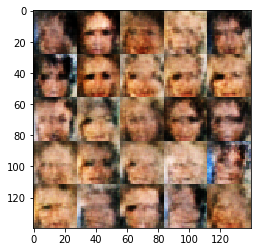

Iteration 1610 -- Epoch 1/1 -- Discriminator loss: 1.32936 -- Generator loss: 0.63925
Iteration 1620 -- Epoch 1/1 -- Discriminator loss: 1.33408 -- Generator loss: 0.61507
Iteration 1630 -- Epoch 1/1 -- Discriminator loss: 1.27450 -- Generator loss: 0.63903
Iteration 1640 -- Epoch 1/1 -- Discriminator loss: 1.30978 -- Generator loss: 0.63593
Iteration 1650 -- Epoch 1/1 -- Discriminator loss: 1.33065 -- Generator loss: 0.61832
Iteration 1660 -- Epoch 1/1 -- Discriminator loss: 1.30613 -- Generator loss: 0.63889
Iteration 1670 -- Epoch 1/1 -- Discriminator loss: 1.29891 -- Generator loss: 0.62505
Iteration 1680 -- Epoch 1/1 -- Discriminator loss: 1.32343 -- Generator loss: 0.60953
Iteration 1690 -- Epoch 1/1 -- Discriminator loss: 1.32383 -- Generator loss: 0.61541
Iteration 1700 -- Epoch 1/1 -- Discriminator loss: 1.28555 -- Generator loss: 0.64372


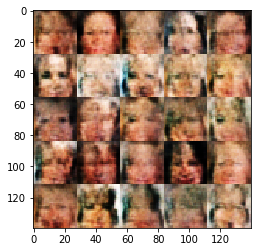

Iteration 1710 -- Epoch 1/1 -- Discriminator loss: 1.30903 -- Generator loss: 0.61880
Iteration 1720 -- Epoch 1/1 -- Discriminator loss: 1.30385 -- Generator loss: 0.61473
Iteration 1730 -- Epoch 1/1 -- Discriminator loss: 1.31905 -- Generator loss: 0.62748
Iteration 1740 -- Epoch 1/1 -- Discriminator loss: 1.29297 -- Generator loss: 0.62813
Iteration 1750 -- Epoch 1/1 -- Discriminator loss: 1.35891 -- Generator loss: 0.60331
Iteration 1760 -- Epoch 1/1 -- Discriminator loss: 1.28685 -- Generator loss: 0.64630
Iteration 1770 -- Epoch 1/1 -- Discriminator loss: 1.34798 -- Generator loss: 0.62897
Iteration 1780 -- Epoch 1/1 -- Discriminator loss: 1.34503 -- Generator loss: 0.63463
Iteration 1790 -- Epoch 1/1 -- Discriminator loss: 1.34659 -- Generator loss: 0.61524
Iteration 1800 -- Epoch 1/1 -- Discriminator loss: 1.27263 -- Generator loss: 0.64931


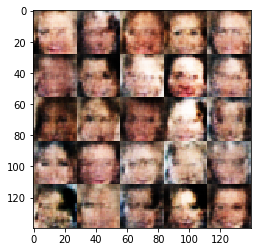

Iteration 1810 -- Epoch 1/1 -- Discriminator loss: 1.33562 -- Generator loss: 0.59218
Iteration 1820 -- Epoch 1/1 -- Discriminator loss: 1.27845 -- Generator loss: 0.63607
Iteration 1830 -- Epoch 1/1 -- Discriminator loss: 1.38862 -- Generator loss: 0.59237
Iteration 1840 -- Epoch 1/1 -- Discriminator loss: 1.29649 -- Generator loss: 0.63831
Iteration 1850 -- Epoch 1/1 -- Discriminator loss: 1.26061 -- Generator loss: 0.65088
Iteration 1860 -- Epoch 1/1 -- Discriminator loss: 1.31755 -- Generator loss: 0.63063
Iteration 1870 -- Epoch 1/1 -- Discriminator loss: 1.37784 -- Generator loss: 0.59912
Iteration 1880 -- Epoch 1/1 -- Discriminator loss: 1.32482 -- Generator loss: 0.58788
Iteration 1890 -- Epoch 1/1 -- Discriminator loss: 1.25872 -- Generator loss: 0.65039
Iteration 1900 -- Epoch 1/1 -- Discriminator loss: 1.33960 -- Generator loss: 0.63335


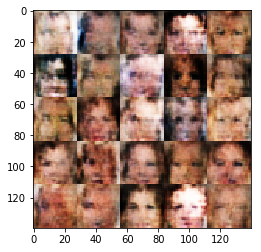

Iteration 1910 -- Epoch 1/1 -- Discriminator loss: 1.24947 -- Generator loss: 0.61892
Iteration 1920 -- Epoch 1/1 -- Discriminator loss: 1.32758 -- Generator loss: 0.62638
Iteration 1930 -- Epoch 1/1 -- Discriminator loss: 1.26153 -- Generator loss: 0.64868
Iteration 1940 -- Epoch 1/1 -- Discriminator loss: 1.31533 -- Generator loss: 0.61777
Iteration 1950 -- Epoch 1/1 -- Discriminator loss: 1.35808 -- Generator loss: 0.55680
Iteration 1960 -- Epoch 1/1 -- Discriminator loss: 1.27038 -- Generator loss: 0.66904
Iteration 1970 -- Epoch 1/1 -- Discriminator loss: 1.21970 -- Generator loss: 0.63024
Iteration 1980 -- Epoch 1/1 -- Discriminator loss: 1.32758 -- Generator loss: 0.61193
Iteration 1990 -- Epoch 1/1 -- Discriminator loss: 1.31947 -- Generator loss: 0.63195
Iteration 2000 -- Epoch 1/1 -- Discriminator loss: 1.32885 -- Generator loss: 0.59099


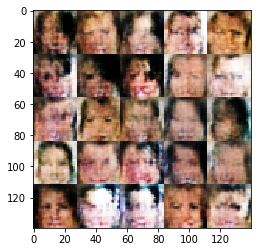

Iteration 2010 -- Epoch 1/1 -- Discriminator loss: 1.33573 -- Generator loss: 0.60363
Iteration 2020 -- Epoch 1/1 -- Discriminator loss: 1.30879 -- Generator loss: 0.62325
Iteration 2030 -- Epoch 1/1 -- Discriminator loss: 1.31663 -- Generator loss: 0.64387
Iteration 2040 -- Epoch 1/1 -- Discriminator loss: 1.21881 -- Generator loss: 0.66791
Iteration 2050 -- Epoch 1/1 -- Discriminator loss: 1.29498 -- Generator loss: 0.64758
Iteration 2060 -- Epoch 1/1 -- Discriminator loss: 1.31142 -- Generator loss: 0.64373
Iteration 2070 -- Epoch 1/1 -- Discriminator loss: 1.29300 -- Generator loss: 0.64466
Iteration 2080 -- Epoch 1/1 -- Discriminator loss: 1.22817 -- Generator loss: 0.65334
Iteration 2090 -- Epoch 1/1 -- Discriminator loss: 1.34377 -- Generator loss: 0.57205
Iteration 2100 -- Epoch 1/1 -- Discriminator loss: 1.29523 -- Generator loss: 0.64033


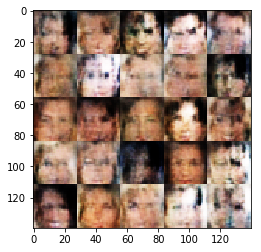

Iteration 2110 -- Epoch 1/1 -- Discriminator loss: 1.35045 -- Generator loss: 0.60611
Iteration 2120 -- Epoch 1/1 -- Discriminator loss: 1.29055 -- Generator loss: 0.59191
Iteration 2130 -- Epoch 1/1 -- Discriminator loss: 1.34017 -- Generator loss: 0.59925
Iteration 2140 -- Epoch 1/1 -- Discriminator loss: 1.29231 -- Generator loss: 0.61765
Iteration 2150 -- Epoch 1/1 -- Discriminator loss: 1.29526 -- Generator loss: 0.64620
Iteration 2160 -- Epoch 1/1 -- Discriminator loss: 1.30255 -- Generator loss: 0.58456
Iteration 2170 -- Epoch 1/1 -- Discriminator loss: 1.28511 -- Generator loss: 0.63093
Iteration 2180 -- Epoch 1/1 -- Discriminator loss: 1.40212 -- Generator loss: 0.57742
Iteration 2190 -- Epoch 1/1 -- Discriminator loss: 1.30767 -- Generator loss: 0.63875
Iteration 2200 -- Epoch 1/1 -- Discriminator loss: 1.35255 -- Generator loss: 0.60456


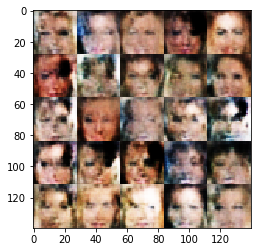

Iteration 2210 -- Epoch 1/1 -- Discriminator loss: 1.32731 -- Generator loss: 0.61679
Iteration 2220 -- Epoch 1/1 -- Discriminator loss: 1.31514 -- Generator loss: 0.61025
Iteration 2230 -- Epoch 1/1 -- Discriminator loss: 1.28781 -- Generator loss: 0.64364
Iteration 2240 -- Epoch 1/1 -- Discriminator loss: 1.29486 -- Generator loss: 0.61478
Iteration 2250 -- Epoch 1/1 -- Discriminator loss: 1.26908 -- Generator loss: 0.66275
Iteration 2260 -- Epoch 1/1 -- Discriminator loss: 1.25545 -- Generator loss: 0.64156
Iteration 2270 -- Epoch 1/1 -- Discriminator loss: 1.31566 -- Generator loss: 0.62718
Iteration 2280 -- Epoch 1/1 -- Discriminator loss: 1.33334 -- Generator loss: 0.62888
Iteration 2290 -- Epoch 1/1 -- Discriminator loss: 1.33765 -- Generator loss: 0.60267
Iteration 2300 -- Epoch 1/1 -- Discriminator loss: 1.33205 -- Generator loss: 0.61351


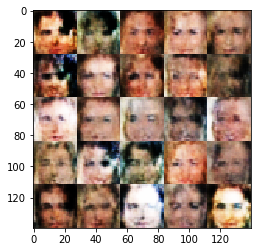

Iteration 2310 -- Epoch 1/1 -- Discriminator loss: 1.23993 -- Generator loss: 0.61329
Iteration 2320 -- Epoch 1/1 -- Discriminator loss: 1.33284 -- Generator loss: 0.62620
Iteration 2330 -- Epoch 1/1 -- Discriminator loss: 1.27796 -- Generator loss: 0.57732
Iteration 2340 -- Epoch 1/1 -- Discriminator loss: 1.31334 -- Generator loss: 0.61212
Iteration 2350 -- Epoch 1/1 -- Discriminator loss: 1.28911 -- Generator loss: 0.63476
Iteration 2360 -- Epoch 1/1 -- Discriminator loss: 1.31524 -- Generator loss: 0.64068
Iteration 2370 -- Epoch 1/1 -- Discriminator loss: 1.28553 -- Generator loss: 0.64212
Iteration 2380 -- Epoch 1/1 -- Discriminator loss: 1.31636 -- Generator loss: 0.62970
Iteration 2390 -- Epoch 1/1 -- Discriminator loss: 1.28269 -- Generator loss: 0.62688
Iteration 2400 -- Epoch 1/1 -- Discriminator loss: 1.26112 -- Generator loss: 0.65484


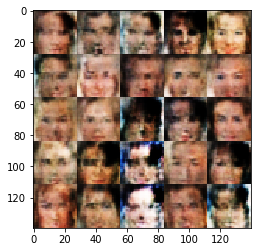

Iteration 2410 -- Epoch 1/1 -- Discriminator loss: 1.30940 -- Generator loss: 0.62737
Iteration 2420 -- Epoch 1/1 -- Discriminator loss: 1.25905 -- Generator loss: 0.64553
Iteration 2430 -- Epoch 1/1 -- Discriminator loss: 1.26859 -- Generator loss: 0.66202
Iteration 2440 -- Epoch 1/1 -- Discriminator loss: 1.31835 -- Generator loss: 0.60571
Iteration 2450 -- Epoch 1/1 -- Discriminator loss: 1.32066 -- Generator loss: 0.63422
Iteration 2460 -- Epoch 1/1 -- Discriminator loss: 1.32228 -- Generator loss: 0.60895
Iteration 2470 -- Epoch 1/1 -- Discriminator loss: 1.32523 -- Generator loss: 0.63810
Iteration 2480 -- Epoch 1/1 -- Discriminator loss: 1.36711 -- Generator loss: 0.60077
Iteration 2490 -- Epoch 1/1 -- Discriminator loss: 1.33371 -- Generator loss: 0.62926
Iteration 2500 -- Epoch 1/1 -- Discriminator loss: 1.30890 -- Generator loss: 0.63518


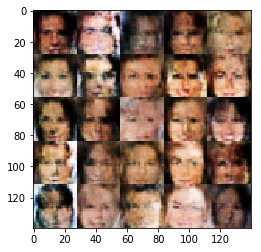

Iteration 2510 -- Epoch 1/1 -- Discriminator loss: 1.34545 -- Generator loss: 0.57785
Iteration 2520 -- Epoch 1/1 -- Discriminator loss: 1.31610 -- Generator loss: 0.62098
Iteration 2530 -- Epoch 1/1 -- Discriminator loss: 1.30259 -- Generator loss: 0.60618
Iteration 2540 -- Epoch 1/1 -- Discriminator loss: 1.31043 -- Generator loss: 0.62361
Iteration 2550 -- Epoch 1/1 -- Discriminator loss: 1.31480 -- Generator loss: 0.62861
Iteration 2560 -- Epoch 1/1 -- Discriminator loss: 1.24879 -- Generator loss: 0.64577
Iteration 2570 -- Epoch 1/1 -- Discriminator loss: 1.27920 -- Generator loss: 0.64243
Iteration 2580 -- Epoch 1/1 -- Discriminator loss: 1.29249 -- Generator loss: 0.60774
Iteration 2590 -- Epoch 1/1 -- Discriminator loss: 1.26075 -- Generator loss: 0.62376
Iteration 2600 -- Epoch 1/1 -- Discriminator loss: 1.28922 -- Generator loss: 0.63895


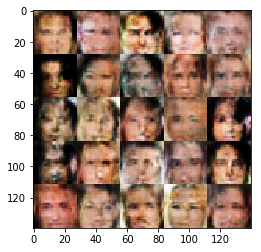

Iteration 2610 -- Epoch 1/1 -- Discriminator loss: 1.27495 -- Generator loss: 0.65076
Iteration 2620 -- Epoch 1/1 -- Discriminator loss: 1.24855 -- Generator loss: 0.65073
Iteration 2630 -- Epoch 1/1 -- Discriminator loss: 1.27494 -- Generator loss: 0.61988
Iteration 2640 -- Epoch 1/1 -- Discriminator loss: 1.28498 -- Generator loss: 0.63908
Iteration 2650 -- Epoch 1/1 -- Discriminator loss: 1.25163 -- Generator loss: 0.66202
Iteration 2660 -- Epoch 1/1 -- Discriminator loss: 1.32312 -- Generator loss: 0.60734
Iteration 2670 -- Epoch 1/1 -- Discriminator loss: 1.31799 -- Generator loss: 0.61452
Iteration 2680 -- Epoch 1/1 -- Discriminator loss: 1.31033 -- Generator loss: 0.63086
Iteration 2690 -- Epoch 1/1 -- Discriminator loss: 1.28113 -- Generator loss: 0.63210
Iteration 2700 -- Epoch 1/1 -- Discriminator loss: 1.28925 -- Generator loss: 0.62885


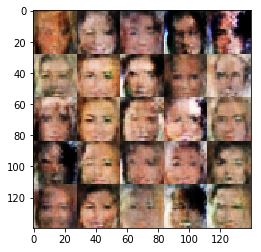

Iteration 2710 -- Epoch 1/1 -- Discriminator loss: 1.30420 -- Generator loss: 0.62420
Iteration 2720 -- Epoch 1/1 -- Discriminator loss: 1.29450 -- Generator loss: 0.63433
Iteration 2730 -- Epoch 1/1 -- Discriminator loss: 1.31181 -- Generator loss: 0.57899
Iteration 2740 -- Epoch 1/1 -- Discriminator loss: 1.33600 -- Generator loss: 0.64534
Iteration 2750 -- Epoch 1/1 -- Discriminator loss: 1.25832 -- Generator loss: 0.63159
Iteration 2760 -- Epoch 1/1 -- Discriminator loss: 1.29776 -- Generator loss: 0.63965
Iteration 2770 -- Epoch 1/1 -- Discriminator loss: 1.28585 -- Generator loss: 0.63367
Iteration 2780 -- Epoch 1/1 -- Discriminator loss: 1.31716 -- Generator loss: 0.67321
Iteration 2790 -- Epoch 1/1 -- Discriminator loss: 1.27953 -- Generator loss: 0.64430
Iteration 2800 -- Epoch 1/1 -- Discriminator loss: 1.28903 -- Generator loss: 0.63738


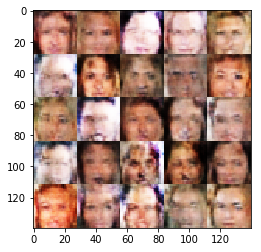

Iteration 2810 -- Epoch 1/1 -- Discriminator loss: 1.29584 -- Generator loss: 0.64491
Iteration 2820 -- Epoch 1/1 -- Discriminator loss: 1.25176 -- Generator loss: 0.65287
Iteration 2830 -- Epoch 1/1 -- Discriminator loss: 1.29029 -- Generator loss: 0.64751
Iteration 2840 -- Epoch 1/1 -- Discriminator loss: 1.32536 -- Generator loss: 0.61469
Iteration 2850 -- Epoch 1/1 -- Discriminator loss: 1.32117 -- Generator loss: 0.62221
Iteration 2860 -- Epoch 1/1 -- Discriminator loss: 1.29527 -- Generator loss: 0.63192
Iteration 2870 -- Epoch 1/1 -- Discriminator loss: 1.26043 -- Generator loss: 0.64161
Iteration 2880 -- Epoch 1/1 -- Discriminator loss: 1.32215 -- Generator loss: 0.58439
Iteration 2890 -- Epoch 1/1 -- Discriminator loss: 1.29426 -- Generator loss: 0.63352
Iteration 2900 -- Epoch 1/1 -- Discriminator loss: 1.32548 -- Generator loss: 0.61544


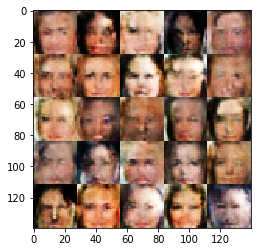

Iteration 2910 -- Epoch 1/1 -- Discriminator loss: 1.29399 -- Generator loss: 0.62580
Iteration 2920 -- Epoch 1/1 -- Discriminator loss: 1.29439 -- Generator loss: 0.63173
Iteration 2930 -- Epoch 1/1 -- Discriminator loss: 1.29172 -- Generator loss: 0.63778
Iteration 2940 -- Epoch 1/1 -- Discriminator loss: 1.30987 -- Generator loss: 0.61188
Iteration 2950 -- Epoch 1/1 -- Discriminator loss: 1.28744 -- Generator loss: 0.63769
Iteration 2960 -- Epoch 1/1 -- Discriminator loss: 1.34676 -- Generator loss: 0.60638
Iteration 2970 -- Epoch 1/1 -- Discriminator loss: 1.30314 -- Generator loss: 0.63386
Iteration 2980 -- Epoch 1/1 -- Discriminator loss: 1.32167 -- Generator loss: 0.62920
Iteration 2990 -- Epoch 1/1 -- Discriminator loss: 1.34605 -- Generator loss: 0.59924
Iteration 3000 -- Epoch 1/1 -- Discriminator loss: 1.30829 -- Generator loss: 0.62817


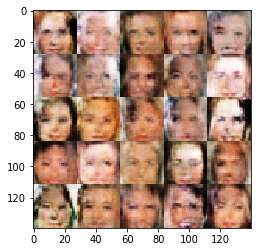

Iteration 3010 -- Epoch 1/1 -- Discriminator loss: 1.33762 -- Generator loss: 0.61479
Iteration 3020 -- Epoch 1/1 -- Discriminator loss: 1.30216 -- Generator loss: 0.62230
Iteration 3030 -- Epoch 1/1 -- Discriminator loss: 1.30810 -- Generator loss: 0.65313
Iteration 3040 -- Epoch 1/1 -- Discriminator loss: 1.32848 -- Generator loss: 0.59295
Iteration 3050 -- Epoch 1/1 -- Discriminator loss: 1.29718 -- Generator loss: 0.61365
Iteration 3060 -- Epoch 1/1 -- Discriminator loss: 1.28898 -- Generator loss: 0.61639
Iteration 3070 -- Epoch 1/1 -- Discriminator loss: 1.29192 -- Generator loss: 0.62940
Iteration 3080 -- Epoch 1/1 -- Discriminator loss: 1.27873 -- Generator loss: 0.64823
Iteration 3090 -- Epoch 1/1 -- Discriminator loss: 1.30061 -- Generator loss: 0.62530
Iteration 3100 -- Epoch 1/1 -- Discriminator loss: 1.31934 -- Generator loss: 0.61891


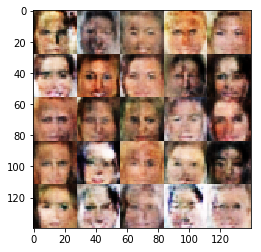

Iteration 3110 -- Epoch 1/1 -- Discriminator loss: 1.29948 -- Generator loss: 0.63656
Iteration 3120 -- Epoch 1/1 -- Discriminator loss: 1.30305 -- Generator loss: 0.61489
Iteration 3130 -- Epoch 1/1 -- Discriminator loss: 1.38813 -- Generator loss: 0.59326
Iteration 3140 -- Epoch 1/1 -- Discriminator loss: 1.31350 -- Generator loss: 0.61836
Iteration 3150 -- Epoch 1/1 -- Discriminator loss: 1.31663 -- Generator loss: 0.61577
Iteration 3160 -- Epoch 1/1 -- Discriminator loss: 1.31000 -- Generator loss: 0.60023
Iteration 3170 -- Epoch 1/1 -- Discriminator loss: 1.36715 -- Generator loss: 0.60528
Iteration 3180 -- Epoch 1/1 -- Discriminator loss: 1.35229 -- Generator loss: 0.63033
Iteration 3190 -- Epoch 1/1 -- Discriminator loss: 1.28886 -- Generator loss: 0.62834
Iteration 3200 -- Epoch 1/1 -- Discriminator loss: 1.31344 -- Generator loss: 0.62855


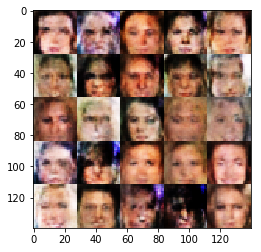

Iteration 3210 -- Epoch 1/1 -- Discriminator loss: 1.29178 -- Generator loss: 0.63949
Iteration 3220 -- Epoch 1/1 -- Discriminator loss: 1.34560 -- Generator loss: 0.60532
Iteration 3230 -- Epoch 1/1 -- Discriminator loss: 1.27893 -- Generator loss: 0.63585
Iteration 3240 -- Epoch 1/1 -- Discriminator loss: 1.31369 -- Generator loss: 0.62869
Iteration 3250 -- Epoch 1/1 -- Discriminator loss: 1.31007 -- Generator loss: 0.58063
Iteration 3260 -- Epoch 1/1 -- Discriminator loss: 1.31853 -- Generator loss: 0.58004
Iteration 3270 -- Epoch 1/1 -- Discriminator loss: 1.27589 -- Generator loss: 0.61749
Iteration 3280 -- Epoch 1/1 -- Discriminator loss: 1.26113 -- Generator loss: 0.64823
Iteration 3290 -- Epoch 1/1 -- Discriminator loss: 1.31339 -- Generator loss: 0.62804
Iteration 3300 -- Epoch 1/1 -- Discriminator loss: 1.27604 -- Generator loss: 0.61406


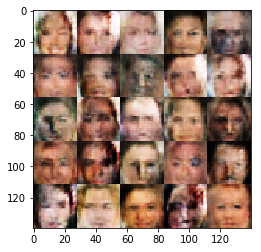

Iteration 3310 -- Epoch 1/1 -- Discriminator loss: 1.27359 -- Generator loss: 0.66979
Iteration 3320 -- Epoch 1/1 -- Discriminator loss: 1.36045 -- Generator loss: 0.58547
Iteration 3330 -- Epoch 1/1 -- Discriminator loss: 1.29590 -- Generator loss: 0.61479
Iteration 3340 -- Epoch 1/1 -- Discriminator loss: 1.34314 -- Generator loss: 0.63522
Iteration 3350 -- Epoch 1/1 -- Discriminator loss: 1.29652 -- Generator loss: 0.59194
Iteration 3360 -- Epoch 1/1 -- Discriminator loss: 1.25260 -- Generator loss: 0.63187
Iteration 3370 -- Epoch 1/1 -- Discriminator loss: 1.29378 -- Generator loss: 0.63853
Iteration 3380 -- Epoch 1/1 -- Discriminator loss: 1.27719 -- Generator loss: 0.64369
Iteration 3390 -- Epoch 1/1 -- Discriminator loss: 1.30278 -- Generator loss: 0.62688
Iteration 3400 -- Epoch 1/1 -- Discriminator loss: 1.28913 -- Generator loss: 0.64260


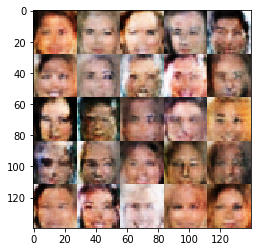

Iteration 3410 -- Epoch 1/1 -- Discriminator loss: 1.31563 -- Generator loss: 0.63289
Iteration 3420 -- Epoch 1/1 -- Discriminator loss: 1.28636 -- Generator loss: 0.62933
Iteration 3430 -- Epoch 1/1 -- Discriminator loss: 1.29166 -- Generator loss: 0.61400
Iteration 3440 -- Epoch 1/1 -- Discriminator loss: 1.28845 -- Generator loss: 0.62657
Iteration 3450 -- Epoch 1/1 -- Discriminator loss: 1.31574 -- Generator loss: 0.62249
Iteration 3460 -- Epoch 1/1 -- Discriminator loss: 1.28488 -- Generator loss: 0.64850
Iteration 3470 -- Epoch 1/1 -- Discriminator loss: 1.29993 -- Generator loss: 0.61468
Iteration 3480 -- Epoch 1/1 -- Discriminator loss: 1.26015 -- Generator loss: 0.65514
Iteration 3490 -- Epoch 1/1 -- Discriminator loss: 1.30077 -- Generator loss: 0.64509
Iteration 3500 -- Epoch 1/1 -- Discriminator loss: 1.28510 -- Generator loss: 0.62194


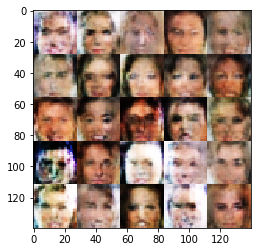

Iteration 3510 -- Epoch 1/1 -- Discriminator loss: 1.46383 -- Generator loss: 0.53721
Iteration 3520 -- Epoch 1/1 -- Discriminator loss: 1.38504 -- Generator loss: 0.59163
Iteration 3530 -- Epoch 1/1 -- Discriminator loss: 1.35941 -- Generator loss: 0.59581
Iteration 3540 -- Epoch 1/1 -- Discriminator loss: 1.26528 -- Generator loss: 0.66182
Iteration 3550 -- Epoch 1/1 -- Discriminator loss: 1.31430 -- Generator loss: 0.60392
Iteration 3560 -- Epoch 1/1 -- Discriminator loss: 1.31694 -- Generator loss: 0.59376
Iteration 3570 -- Epoch 1/1 -- Discriminator loss: 1.32000 -- Generator loss: 0.60622
Iteration 3580 -- Epoch 1/1 -- Discriminator loss: 1.28461 -- Generator loss: 0.65262
Iteration 3590 -- Epoch 1/1 -- Discriminator loss: 1.27025 -- Generator loss: 0.61062
Iteration 3600 -- Epoch 1/1 -- Discriminator loss: 1.52668 -- Generator loss: 0.46418


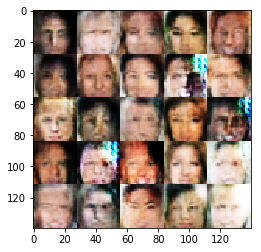

Iteration 3610 -- Epoch 1/1 -- Discriminator loss: 1.25715 -- Generator loss: 0.66763
Iteration 3620 -- Epoch 1/1 -- Discriminator loss: 1.32468 -- Generator loss: 0.62712
Iteration 3630 -- Epoch 1/1 -- Discriminator loss: 1.33093 -- Generator loss: 0.59788
Iteration 3640 -- Epoch 1/1 -- Discriminator loss: 1.26750 -- Generator loss: 0.60175
Iteration 3650 -- Epoch 1/1 -- Discriminator loss: 1.32570 -- Generator loss: 0.58708
Iteration 3660 -- Epoch 1/1 -- Discriminator loss: 1.26841 -- Generator loss: 0.64345
Iteration 3670 -- Epoch 1/1 -- Discriminator loss: 1.24932 -- Generator loss: 0.63955
Iteration 3680 -- Epoch 1/1 -- Discriminator loss: 1.26702 -- Generator loss: 0.62628
Iteration 3690 -- Epoch 1/1 -- Discriminator loss: 1.26737 -- Generator loss: 0.61610
Iteration 3700 -- Epoch 1/1 -- Discriminator loss: 1.35257 -- Generator loss: 0.58260


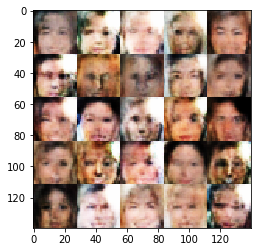

Iteration 3710 -- Epoch 1/1 -- Discriminator loss: 1.29432 -- Generator loss: 0.62134
Iteration 3720 -- Epoch 1/1 -- Discriminator loss: 1.31200 -- Generator loss: 0.61985
Iteration 3730 -- Epoch 1/1 -- Discriminator loss: 1.26560 -- Generator loss: 0.64820
Iteration 3740 -- Epoch 1/1 -- Discriminator loss: 1.30284 -- Generator loss: 0.61806
Iteration 3750 -- Epoch 1/1 -- Discriminator loss: 1.32491 -- Generator loss: 0.59259
Iteration 3760 -- Epoch 1/1 -- Discriminator loss: 1.25455 -- Generator loss: 0.64023
Iteration 3770 -- Epoch 1/1 -- Discriminator loss: 1.27828 -- Generator loss: 0.62465
Iteration 3780 -- Epoch 1/1 -- Discriminator loss: 1.28348 -- Generator loss: 0.61433
Iteration 3790 -- Epoch 1/1 -- Discriminator loss: 1.31755 -- Generator loss: 0.60486
Iteration 3800 -- Epoch 1/1 -- Discriminator loss: 1.26803 -- Generator loss: 0.62164


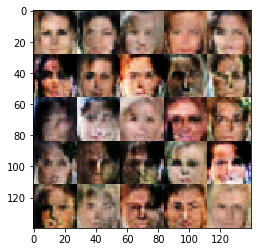

Iteration 3810 -- Epoch 1/1 -- Discriminator loss: 1.33150 -- Generator loss: 0.60833
Iteration 3820 -- Epoch 1/1 -- Discriminator loss: 1.29534 -- Generator loss: 0.63917
Iteration 3830 -- Epoch 1/1 -- Discriminator loss: 1.27474 -- Generator loss: 0.63162
Iteration 3840 -- Epoch 1/1 -- Discriminator loss: 1.30659 -- Generator loss: 0.63027
Iteration 3850 -- Epoch 1/1 -- Discriminator loss: 1.26697 -- Generator loss: 0.64503
Iteration 3860 -- Epoch 1/1 -- Discriminator loss: 1.29224 -- Generator loss: 0.61709
Iteration 3870 -- Epoch 1/1 -- Discriminator loss: 1.28412 -- Generator loss: 0.60335
Iteration 3880 -- Epoch 1/1 -- Discriminator loss: 1.32138 -- Generator loss: 0.60032
Iteration 3890 -- Epoch 1/1 -- Discriminator loss: 1.28210 -- Generator loss: 0.62138
Iteration 3900 -- Epoch 1/1 -- Discriminator loss: 1.28614 -- Generator loss: 0.61572


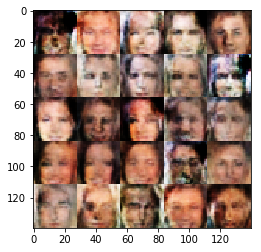

Iteration 3910 -- Epoch 1/1 -- Discriminator loss: 1.28665 -- Generator loss: 0.62603
Iteration 3920 -- Epoch 1/1 -- Discriminator loss: 1.32919 -- Generator loss: 0.61049
Iteration 3930 -- Epoch 1/1 -- Discriminator loss: 1.29929 -- Generator loss: 0.64592
Iteration 3940 -- Epoch 1/1 -- Discriminator loss: 1.28801 -- Generator loss: 0.61861
Iteration 3950 -- Epoch 1/1 -- Discriminator loss: 1.28987 -- Generator loss: 0.61368
Iteration 3960 -- Epoch 1/1 -- Discriminator loss: 1.29227 -- Generator loss: 0.62756
Iteration 3970 -- Epoch 1/1 -- Discriminator loss: 1.30504 -- Generator loss: 0.61068
Iteration 3980 -- Epoch 1/1 -- Discriminator loss: 1.28793 -- Generator loss: 0.64627
Iteration 3990 -- Epoch 1/1 -- Discriminator loss: 1.24768 -- Generator loss: 0.63844
Iteration 4000 -- Epoch 1/1 -- Discriminator loss: 1.24747 -- Generator loss: 0.63288


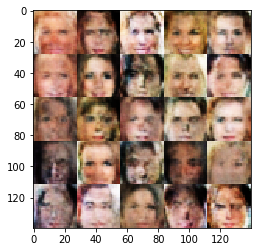

Iteration 4010 -- Epoch 1/1 -- Discriminator loss: 1.28693 -- Generator loss: 0.64067
Iteration 4020 -- Epoch 1/1 -- Discriminator loss: 1.27310 -- Generator loss: 0.64373
Iteration 4030 -- Epoch 1/1 -- Discriminator loss: 1.28975 -- Generator loss: 0.60193
Iteration 4040 -- Epoch 1/1 -- Discriminator loss: 1.31194 -- Generator loss: 0.60495
Iteration 4050 -- Epoch 1/1 -- Discriminator loss: 1.31530 -- Generator loss: 0.61319
Iteration 4060 -- Epoch 1/1 -- Discriminator loss: 1.24853 -- Generator loss: 0.63021
Iteration 4070 -- Epoch 1/1 -- Discriminator loss: 1.30711 -- Generator loss: 0.61128
Iteration 4080 -- Epoch 1/1 -- Discriminator loss: 1.29740 -- Generator loss: 0.64913
Iteration 4090 -- Epoch 1/1 -- Discriminator loss: 1.30513 -- Generator loss: 0.61157
Iteration 4100 -- Epoch 1/1 -- Discriminator loss: 1.31475 -- Generator loss: 0.60770


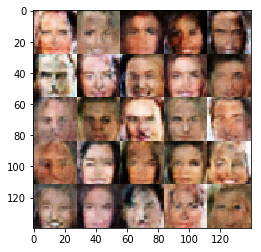

Iteration 4110 -- Epoch 1/1 -- Discriminator loss: 1.31249 -- Generator loss: 0.64010
Iteration 4120 -- Epoch 1/1 -- Discriminator loss: 1.30072 -- Generator loss: 0.63136
Iteration 4130 -- Epoch 1/1 -- Discriminator loss: 1.31001 -- Generator loss: 0.62513
Iteration 4140 -- Epoch 1/1 -- Discriminator loss: 1.31501 -- Generator loss: 0.62897
Iteration 4150 -- Epoch 1/1 -- Discriminator loss: 1.26900 -- Generator loss: 0.62955
Iteration 4160 -- Epoch 1/1 -- Discriminator loss: 1.36626 -- Generator loss: 0.59281
Iteration 4170 -- Epoch 1/1 -- Discriminator loss: 1.29620 -- Generator loss: 0.62465
Iteration 4180 -- Epoch 1/1 -- Discriminator loss: 1.27700 -- Generator loss: 0.62049
Iteration 4190 -- Epoch 1/1 -- Discriminator loss: 1.28416 -- Generator loss: 0.62597
Iteration 4200 -- Epoch 1/1 -- Discriminator loss: 1.28840 -- Generator loss: 0.65749


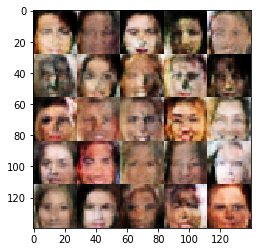

Iteration 4210 -- Epoch 1/1 -- Discriminator loss: 1.32704 -- Generator loss: 0.62395
Iteration 4220 -- Epoch 1/1 -- Discriminator loss: 1.30652 -- Generator loss: 0.61654
Iteration 4230 -- Epoch 1/1 -- Discriminator loss: 1.33930 -- Generator loss: 0.61478
Iteration 4240 -- Epoch 1/1 -- Discriminator loss: 1.30649 -- Generator loss: 0.62093
Iteration 4250 -- Epoch 1/1 -- Discriminator loss: 1.26801 -- Generator loss: 0.64585
Iteration 4260 -- Epoch 1/1 -- Discriminator loss: 1.29224 -- Generator loss: 0.61751
Iteration 4270 -- Epoch 1/1 -- Discriminator loss: 1.27371 -- Generator loss: 0.65222
Iteration 4280 -- Epoch 1/1 -- Discriminator loss: 1.29712 -- Generator loss: 0.62083
Iteration 4290 -- Epoch 1/1 -- Discriminator loss: 1.28714 -- Generator loss: 0.63395
Iteration 4300 -- Epoch 1/1 -- Discriminator loss: 1.39874 -- Generator loss: 0.56477


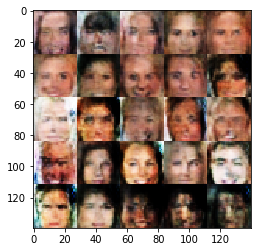

Iteration 4310 -- Epoch 1/1 -- Discriminator loss: 1.31271 -- Generator loss: 0.58328
Iteration 4320 -- Epoch 1/1 -- Discriminator loss: 1.30860 -- Generator loss: 0.59048
Iteration 4330 -- Epoch 1/1 -- Discriminator loss: 1.31622 -- Generator loss: 0.60312
Iteration 4340 -- Epoch 1/1 -- Discriminator loss: 1.29658 -- Generator loss: 0.60125
Iteration 4350 -- Epoch 1/1 -- Discriminator loss: 1.28136 -- Generator loss: 0.61432
Iteration 4360 -- Epoch 1/1 -- Discriminator loss: 1.28648 -- Generator loss: 0.63219
Iteration 4370 -- Epoch 1/1 -- Discriminator loss: 1.24461 -- Generator loss: 0.63811
Iteration 4380 -- Epoch 1/1 -- Discriminator loss: 1.27564 -- Generator loss: 0.61923
Iteration 4390 -- Epoch 1/1 -- Discriminator loss: 1.29610 -- Generator loss: 0.60960
Iteration 4400 -- Epoch 1/1 -- Discriminator loss: 1.25601 -- Generator loss: 0.62954


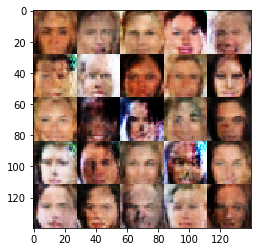

Iteration 4410 -- Epoch 1/1 -- Discriminator loss: 1.31825 -- Generator loss: 0.59893
Iteration 4420 -- Epoch 1/1 -- Discriminator loss: 1.29360 -- Generator loss: 0.61244
Iteration 4430 -- Epoch 1/1 -- Discriminator loss: 1.31105 -- Generator loss: 0.59978
Iteration 4440 -- Epoch 1/1 -- Discriminator loss: 1.31558 -- Generator loss: 0.58354
Iteration 4450 -- Epoch 1/1 -- Discriminator loss: 1.30440 -- Generator loss: 0.61212
Iteration 4460 -- Epoch 1/1 -- Discriminator loss: 1.28677 -- Generator loss: 0.64498
Iteration 4470 -- Epoch 1/1 -- Discriminator loss: 1.30027 -- Generator loss: 0.60635
Iteration 4480 -- Epoch 1/1 -- Discriminator loss: 1.33039 -- Generator loss: 0.58983
Iteration 4490 -- Epoch 1/1 -- Discriminator loss: 1.31223 -- Generator loss: 0.60907
Iteration 4500 -- Epoch 1/1 -- Discriminator loss: 1.25373 -- Generator loss: 0.62374


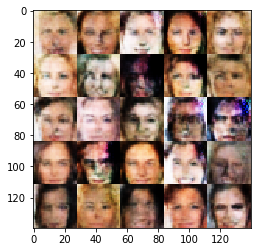

Iteration 4510 -- Epoch 1/1 -- Discriminator loss: 1.31106 -- Generator loss: 0.60411
Iteration 4520 -- Epoch 1/1 -- Discriminator loss: 1.30567 -- Generator loss: 0.60762
Iteration 4530 -- Epoch 1/1 -- Discriminator loss: 1.37137 -- Generator loss: 0.59254
Iteration 4540 -- Epoch 1/1 -- Discriminator loss: 1.32355 -- Generator loss: 0.61640
Iteration 4550 -- Epoch 1/1 -- Discriminator loss: 1.31906 -- Generator loss: 0.60025
Iteration 4560 -- Epoch 1/1 -- Discriminator loss: 1.27853 -- Generator loss: 0.62884
Iteration 4570 -- Epoch 1/1 -- Discriminator loss: 1.30728 -- Generator loss: 0.62910
Iteration 4580 -- Epoch 1/1 -- Discriminator loss: 1.30536 -- Generator loss: 0.61014
Iteration 4590 -- Epoch 1/1 -- Discriminator loss: 1.30806 -- Generator loss: 0.61323
Iteration 4600 -- Epoch 1/1 -- Discriminator loss: 1.29100 -- Generator loss: 0.65194


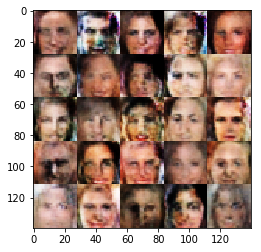

Iteration 4610 -- Epoch 1/1 -- Discriminator loss: 1.26926 -- Generator loss: 0.63206
Iteration 4620 -- Epoch 1/1 -- Discriminator loss: 1.28980 -- Generator loss: 0.63326
Iteration 4630 -- Epoch 1/1 -- Discriminator loss: 1.28983 -- Generator loss: 0.63660
Iteration 4640 -- Epoch 1/1 -- Discriminator loss: 1.28931 -- Generator loss: 0.63546
Iteration 4650 -- Epoch 1/1 -- Discriminator loss: 1.28375 -- Generator loss: 0.62772
Iteration 4660 -- Epoch 1/1 -- Discriminator loss: 1.29912 -- Generator loss: 0.62395
Iteration 4670 -- Epoch 1/1 -- Discriminator loss: 1.28970 -- Generator loss: 0.64020
Iteration 4680 -- Epoch 1/1 -- Discriminator loss: 1.30175 -- Generator loss: 0.62019
Iteration 4690 -- Epoch 1/1 -- Discriminator loss: 1.27510 -- Generator loss: 0.64748
Iteration 4700 -- Epoch 1/1 -- Discriminator loss: 1.27583 -- Generator loss: 0.63902


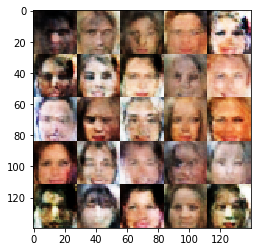

Iteration 4710 -- Epoch 1/1 -- Discriminator loss: 1.31889 -- Generator loss: 0.61937
Iteration 4720 -- Epoch 1/1 -- Discriminator loss: 1.30304 -- Generator loss: 0.59819
Iteration 4730 -- Epoch 1/1 -- Discriminator loss: 1.31726 -- Generator loss: 0.61718
Iteration 4740 -- Epoch 1/1 -- Discriminator loss: 1.27321 -- Generator loss: 0.61699
Iteration 4750 -- Epoch 1/1 -- Discriminator loss: 1.27704 -- Generator loss: 0.64696
Iteration 4760 -- Epoch 1/1 -- Discriminator loss: 1.31932 -- Generator loss: 0.61327
Iteration 4770 -- Epoch 1/1 -- Discriminator loss: 1.29779 -- Generator loss: 0.62735
Iteration 4780 -- Epoch 1/1 -- Discriminator loss: 1.29374 -- Generator loss: 0.66575
Iteration 4790 -- Epoch 1/1 -- Discriminator loss: 1.35439 -- Generator loss: 0.58403
Iteration 4800 -- Epoch 1/1 -- Discriminator loss: 1.28645 -- Generator loss: 0.62957


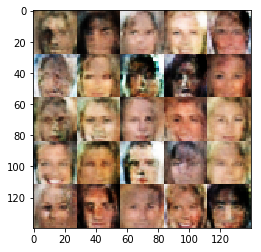

Iteration 4810 -- Epoch 1/1 -- Discriminator loss: 1.32053 -- Generator loss: 0.60272
Iteration 4820 -- Epoch 1/1 -- Discriminator loss: 1.28156 -- Generator loss: 0.60254
Iteration 4830 -- Epoch 1/1 -- Discriminator loss: 1.29567 -- Generator loss: 0.63493
Iteration 4840 -- Epoch 1/1 -- Discriminator loss: 1.27854 -- Generator loss: 0.63981
Iteration 4850 -- Epoch 1/1 -- Discriminator loss: 1.28982 -- Generator loss: 0.62543
Iteration 4860 -- Epoch 1/1 -- Discriminator loss: 1.31301 -- Generator loss: 0.61388
Iteration 4870 -- Epoch 1/1 -- Discriminator loss: 1.25861 -- Generator loss: 0.63064
Iteration 4880 -- Epoch 1/1 -- Discriminator loss: 1.32224 -- Generator loss: 0.58711
Iteration 4890 -- Epoch 1/1 -- Discriminator loss: 1.27093 -- Generator loss: 0.61951
Iteration 4900 -- Epoch 1/1 -- Discriminator loss: 1.30560 -- Generator loss: 0.63000


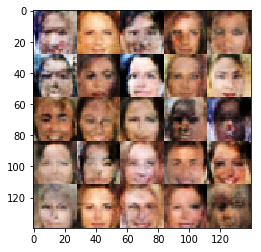

Iteration 4910 -- Epoch 1/1 -- Discriminator loss: 1.28489 -- Generator loss: 0.63812
Iteration 4920 -- Epoch 1/1 -- Discriminator loss: 1.26706 -- Generator loss: 0.63232
Iteration 4930 -- Epoch 1/1 -- Discriminator loss: 1.34028 -- Generator loss: 0.62060
Iteration 4940 -- Epoch 1/1 -- Discriminator loss: 1.30184 -- Generator loss: 0.64684
Iteration 4950 -- Epoch 1/1 -- Discriminator loss: 1.29785 -- Generator loss: 0.60945
Iteration 4960 -- Epoch 1/1 -- Discriminator loss: 1.31310 -- Generator loss: 0.63868
Iteration 4970 -- Epoch 1/1 -- Discriminator loss: 1.30469 -- Generator loss: 0.58836
Iteration 4980 -- Epoch 1/1 -- Discriminator loss: 1.25840 -- Generator loss: 0.63832
Iteration 4990 -- Epoch 1/1 -- Discriminator loss: 1.30104 -- Generator loss: 0.61535
Iteration 5000 -- Epoch 1/1 -- Discriminator loss: 1.27708 -- Generator loss: 0.62806


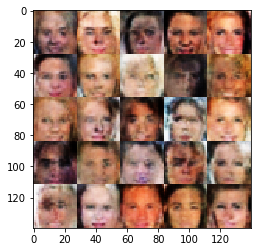

Iteration 5010 -- Epoch 1/1 -- Discriminator loss: 1.31243 -- Generator loss: 0.61264
Iteration 5020 -- Epoch 1/1 -- Discriminator loss: 1.27850 -- Generator loss: 0.62820
Iteration 5030 -- Epoch 1/1 -- Discriminator loss: 1.29698 -- Generator loss: 0.62148
Iteration 5040 -- Epoch 1/1 -- Discriminator loss: 1.27887 -- Generator loss: 0.62706
Iteration 5050 -- Epoch 1/1 -- Discriminator loss: 1.26844 -- Generator loss: 0.63100
Iteration 5060 -- Epoch 1/1 -- Discriminator loss: 1.29310 -- Generator loss: 0.63621
Iteration 5070 -- Epoch 1/1 -- Discriminator loss: 1.24285 -- Generator loss: 0.64053
Iteration 5080 -- Epoch 1/1 -- Discriminator loss: 1.30289 -- Generator loss: 0.61696
Iteration 5090 -- Epoch 1/1 -- Discriminator loss: 1.30232 -- Generator loss: 0.64081
Iteration 5100 -- Epoch 1/1 -- Discriminator loss: 1.26395 -- Generator loss: 0.64536


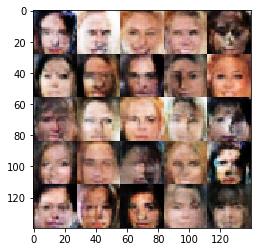

Iteration 5110 -- Epoch 1/1 -- Discriminator loss: 1.27235 -- Generator loss: 0.64570
Iteration 5120 -- Epoch 1/1 -- Discriminator loss: 1.29554 -- Generator loss: 0.62452
Iteration 5130 -- Epoch 1/1 -- Discriminator loss: 1.26509 -- Generator loss: 0.62192
Iteration 5140 -- Epoch 1/1 -- Discriminator loss: 1.30134 -- Generator loss: 0.62550
Iteration 5150 -- Epoch 1/1 -- Discriminator loss: 1.28082 -- Generator loss: 0.62736
Iteration 5160 -- Epoch 1/1 -- Discriminator loss: 1.30793 -- Generator loss: 0.61964
Iteration 5170 -- Epoch 1/1 -- Discriminator loss: 1.27684 -- Generator loss: 0.63184
Iteration 5180 -- Epoch 1/1 -- Discriminator loss: 1.26363 -- Generator loss: 0.61821
Iteration 5190 -- Epoch 1/1 -- Discriminator loss: 1.26920 -- Generator loss: 0.65723
Iteration 5200 -- Epoch 1/1 -- Discriminator loss: 1.29811 -- Generator loss: 0.66267


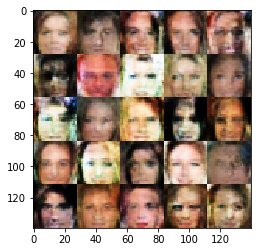

Iteration 5210 -- Epoch 1/1 -- Discriminator loss: 1.30132 -- Generator loss: 0.61760
Iteration 5220 -- Epoch 1/1 -- Discriminator loss: 1.29640 -- Generator loss: 0.62840
Iteration 5230 -- Epoch 1/1 -- Discriminator loss: 1.28482 -- Generator loss: 0.64732
Iteration 5240 -- Epoch 1/1 -- Discriminator loss: 1.27451 -- Generator loss: 0.63433
Iteration 5250 -- Epoch 1/1 -- Discriminator loss: 1.28619 -- Generator loss: 0.63219
Iteration 5260 -- Epoch 1/1 -- Discriminator loss: 1.29141 -- Generator loss: 0.64309
Iteration 5270 -- Epoch 1/1 -- Discriminator loss: 1.26163 -- Generator loss: 0.63326
Iteration 5280 -- Epoch 1/1 -- Discriminator loss: 1.29559 -- Generator loss: 0.62607
Iteration 5290 -- Epoch 1/1 -- Discriminator loss: 1.27407 -- Generator loss: 0.63159
Iteration 5300 -- Epoch 1/1 -- Discriminator loss: 1.28025 -- Generator loss: 0.66252


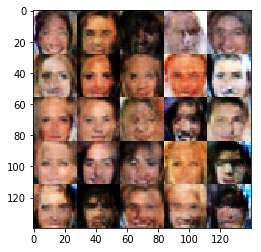

Iteration 5310 -- Epoch 1/1 -- Discriminator loss: 1.30597 -- Generator loss: 0.61663
Iteration 5320 -- Epoch 1/1 -- Discriminator loss: 1.30049 -- Generator loss: 0.64149
Iteration 5330 -- Epoch 1/1 -- Discriminator loss: 1.32783 -- Generator loss: 0.60766
Iteration 5340 -- Epoch 1/1 -- Discriminator loss: 1.28829 -- Generator loss: 0.62229
Iteration 5350 -- Epoch 1/1 -- Discriminator loss: 1.32406 -- Generator loss: 0.57531
Iteration 5360 -- Epoch 1/1 -- Discriminator loss: 1.32531 -- Generator loss: 0.61519
Iteration 5370 -- Epoch 1/1 -- Discriminator loss: 1.24926 -- Generator loss: 0.65849
Iteration 5380 -- Epoch 1/1 -- Discriminator loss: 1.26485 -- Generator loss: 0.65151
Iteration 5390 -- Epoch 1/1 -- Discriminator loss: 1.30663 -- Generator loss: 0.60567
Iteration 5400 -- Epoch 1/1 -- Discriminator loss: 1.27785 -- Generator loss: 0.65222


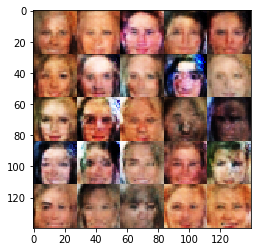

Iteration 5410 -- Epoch 1/1 -- Discriminator loss: 1.25791 -- Generator loss: 0.63985
Iteration 5420 -- Epoch 1/1 -- Discriminator loss: 1.27250 -- Generator loss: 0.61697
Iteration 5430 -- Epoch 1/1 -- Discriminator loss: 1.31156 -- Generator loss: 0.60018
Iteration 5440 -- Epoch 1/1 -- Discriminator loss: 1.32325 -- Generator loss: 0.59845
Iteration 5450 -- Epoch 1/1 -- Discriminator loss: 1.24557 -- Generator loss: 0.63148
Iteration 5460 -- Epoch 1/1 -- Discriminator loss: 1.24656 -- Generator loss: 0.65666
Iteration 5470 -- Epoch 1/1 -- Discriminator loss: 1.25199 -- Generator loss: 0.62701
Iteration 5480 -- Epoch 1/1 -- Discriminator loss: 1.31553 -- Generator loss: 0.58391
Iteration 5490 -- Epoch 1/1 -- Discriminator loss: 1.29513 -- Generator loss: 0.61771
Iteration 5500 -- Epoch 1/1 -- Discriminator loss: 1.33466 -- Generator loss: 0.60949


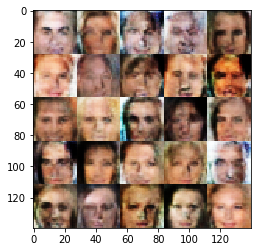

Iteration 5510 -- Epoch 1/1 -- Discriminator loss: 1.31918 -- Generator loss: 0.59170
Iteration 5520 -- Epoch 1/1 -- Discriminator loss: 1.26508 -- Generator loss: 0.63375
Iteration 5530 -- Epoch 1/1 -- Discriminator loss: 1.29553 -- Generator loss: 0.62325
Iteration 5540 -- Epoch 1/1 -- Discriminator loss: 1.27567 -- Generator loss: 0.62930
Iteration 5550 -- Epoch 1/1 -- Discriminator loss: 1.27924 -- Generator loss: 0.65951
Iteration 5560 -- Epoch 1/1 -- Discriminator loss: 1.32223 -- Generator loss: 0.59280
Iteration 5570 -- Epoch 1/1 -- Discriminator loss: 1.27389 -- Generator loss: 0.63933
Iteration 5580 -- Epoch 1/1 -- Discriminator loss: 1.27868 -- Generator loss: 0.62706
Iteration 5590 -- Epoch 1/1 -- Discriminator loss: 1.28584 -- Generator loss: 0.63345
Iteration 5600 -- Epoch 1/1 -- Discriminator loss: 1.28161 -- Generator loss: 0.63760


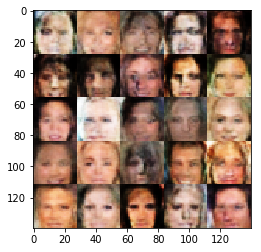

Iteration 5610 -- Epoch 1/1 -- Discriminator loss: 1.25783 -- Generator loss: 0.62961
Iteration 5620 -- Epoch 1/1 -- Discriminator loss: 1.29844 -- Generator loss: 0.61227
Iteration 5630 -- Epoch 1/1 -- Discriminator loss: 1.33270 -- Generator loss: 0.60313
Iteration 5640 -- Epoch 1/1 -- Discriminator loss: 1.27719 -- Generator loss: 0.62879
Iteration 5650 -- Epoch 1/1 -- Discriminator loss: 1.30802 -- Generator loss: 0.62492
Iteration 5660 -- Epoch 1/1 -- Discriminator loss: 1.29327 -- Generator loss: 0.63418
Iteration 5670 -- Epoch 1/1 -- Discriminator loss: 1.24931 -- Generator loss: 0.65380
Iteration 5680 -- Epoch 1/1 -- Discriminator loss: 1.27609 -- Generator loss: 0.65399
Iteration 5690 -- Epoch 1/1 -- Discriminator loss: 1.33248 -- Generator loss: 0.61315
Iteration 5700 -- Epoch 1/1 -- Discriminator loss: 1.29023 -- Generator loss: 0.62376


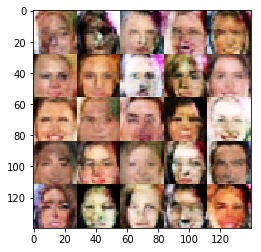

Iteration 5710 -- Epoch 1/1 -- Discriminator loss: 1.28553 -- Generator loss: 0.64366
Iteration 5720 -- Epoch 1/1 -- Discriminator loss: 1.27143 -- Generator loss: 0.61165
Iteration 5730 -- Epoch 1/1 -- Discriminator loss: 1.28368 -- Generator loss: 0.61771
Iteration 5740 -- Epoch 1/1 -- Discriminator loss: 1.27227 -- Generator loss: 0.66843
Iteration 5750 -- Epoch 1/1 -- Discriminator loss: 1.29111 -- Generator loss: 0.62928
Iteration 5760 -- Epoch 1/1 -- Discriminator loss: 1.32101 -- Generator loss: 0.61747
Iteration 5770 -- Epoch 1/1 -- Discriminator loss: 1.33423 -- Generator loss: 0.63843
Iteration 5780 -- Epoch 1/1 -- Discriminator loss: 1.28881 -- Generator loss: 0.61572
Iteration 5790 -- Epoch 1/1 -- Discriminator loss: 1.31810 -- Generator loss: 0.61878
Iteration 5800 -- Epoch 1/1 -- Discriminator loss: 1.29419 -- Generator loss: 0.63047


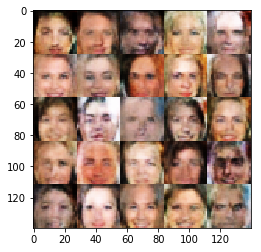

Iteration 5810 -- Epoch 1/1 -- Discriminator loss: 1.35413 -- Generator loss: 0.59374
Iteration 5820 -- Epoch 1/1 -- Discriminator loss: 1.29836 -- Generator loss: 0.60915
Iteration 5830 -- Epoch 1/1 -- Discriminator loss: 1.30730 -- Generator loss: 0.59771
Iteration 5840 -- Epoch 1/1 -- Discriminator loss: 1.27333 -- Generator loss: 0.60175
Iteration 5850 -- Epoch 1/1 -- Discriminator loss: 1.31155 -- Generator loss: 0.64265
Iteration 5860 -- Epoch 1/1 -- Discriminator loss: 1.25730 -- Generator loss: 0.63297
Iteration 5870 -- Epoch 1/1 -- Discriminator loss: 1.30903 -- Generator loss: 0.62539
Iteration 5880 -- Epoch 1/1 -- Discriminator loss: 1.28709 -- Generator loss: 0.62064
Iteration 5890 -- Epoch 1/1 -- Discriminator loss: 1.29505 -- Generator loss: 0.61943
Iteration 5900 -- Epoch 1/1 -- Discriminator loss: 1.36220 -- Generator loss: 0.57221


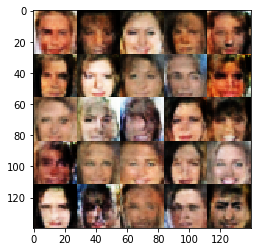

Iteration 5910 -- Epoch 1/1 -- Discriminator loss: 1.27349 -- Generator loss: 0.64098
Iteration 5920 -- Epoch 1/1 -- Discriminator loss: 1.35556 -- Generator loss: 0.56807
Iteration 5930 -- Epoch 1/1 -- Discriminator loss: 1.32295 -- Generator loss: 0.61985
Iteration 5940 -- Epoch 1/1 -- Discriminator loss: 1.28076 -- Generator loss: 0.62811
Iteration 5950 -- Epoch 1/1 -- Discriminator loss: 1.31626 -- Generator loss: 0.60531
Iteration 5960 -- Epoch 1/1 -- Discriminator loss: 1.31478 -- Generator loss: 0.61106
Iteration 5970 -- Epoch 1/1 -- Discriminator loss: 1.24025 -- Generator loss: 0.65896
Iteration 5980 -- Epoch 1/1 -- Discriminator loss: 1.29527 -- Generator loss: 0.61425
Iteration 5990 -- Epoch 1/1 -- Discriminator loss: 1.30724 -- Generator loss: 0.65064
Iteration 6000 -- Epoch 1/1 -- Discriminator loss: 1.27599 -- Generator loss: 0.63436


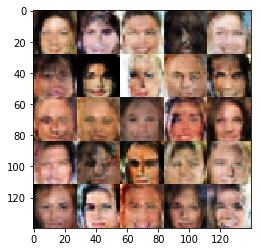

Iteration 6010 -- Epoch 1/1 -- Discriminator loss: 1.29214 -- Generator loss: 0.62529
Iteration 6020 -- Epoch 1/1 -- Discriminator loss: 1.30509 -- Generator loss: 0.64522
Iteration 6030 -- Epoch 1/1 -- Discriminator loss: 1.33689 -- Generator loss: 0.60157
Iteration 6040 -- Epoch 1/1 -- Discriminator loss: 1.32220 -- Generator loss: 0.63507
Iteration 6050 -- Epoch 1/1 -- Discriminator loss: 1.37534 -- Generator loss: 0.59180
Iteration 6060 -- Epoch 1/1 -- Discriminator loss: 1.28226 -- Generator loss: 0.61972
Iteration 6070 -- Epoch 1/1 -- Discriminator loss: 1.30183 -- Generator loss: 0.64002
Iteration 6080 -- Epoch 1/1 -- Discriminator loss: 1.30197 -- Generator loss: 0.60466
Iteration 6090 -- Epoch 1/1 -- Discriminator loss: 1.29174 -- Generator loss: 0.59855
Iteration 6100 -- Epoch 1/1 -- Discriminator loss: 1.27081 -- Generator loss: 0.66738


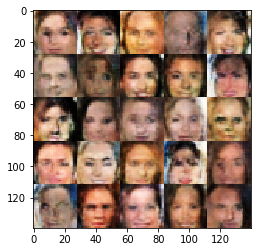

Iteration 6110 -- Epoch 1/1 -- Discriminator loss: 1.29765 -- Generator loss: 0.59842
Iteration 6120 -- Epoch 1/1 -- Discriminator loss: 1.26117 -- Generator loss: 0.64961
Iteration 6130 -- Epoch 1/1 -- Discriminator loss: 1.28100 -- Generator loss: 0.60823
Iteration 6140 -- Epoch 1/1 -- Discriminator loss: 1.27361 -- Generator loss: 0.61444
Iteration 6150 -- Epoch 1/1 -- Discriminator loss: 1.29534 -- Generator loss: 0.62961
Iteration 6160 -- Epoch 1/1 -- Discriminator loss: 1.28737 -- Generator loss: 0.62539
Iteration 6170 -- Epoch 1/1 -- Discriminator loss: 1.28006 -- Generator loss: 0.63375
Iteration 6180 -- Epoch 1/1 -- Discriminator loss: 1.31972 -- Generator loss: 0.61149
Iteration 6190 -- Epoch 1/1 -- Discriminator loss: 1.27023 -- Generator loss: 0.61865
Iteration 6200 -- Epoch 1/1 -- Discriminator loss: 1.23379 -- Generator loss: 0.66449


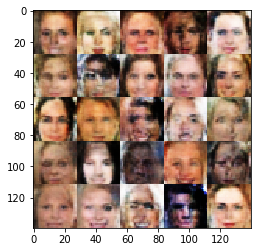

Iteration 6210 -- Epoch 1/1 -- Discriminator loss: 1.32165 -- Generator loss: 0.61591
Iteration 6220 -- Epoch 1/1 -- Discriminator loss: 1.30777 -- Generator loss: 0.60071
Iteration 6230 -- Epoch 1/1 -- Discriminator loss: 1.30063 -- Generator loss: 0.62240
Iteration 6240 -- Epoch 1/1 -- Discriminator loss: 1.30137 -- Generator loss: 0.59554
Iteration 6250 -- Epoch 1/1 -- Discriminator loss: 1.30612 -- Generator loss: 0.60883
Iteration 6260 -- Epoch 1/1 -- Discriminator loss: 1.24864 -- Generator loss: 0.64844
Iteration 6270 -- Epoch 1/1 -- Discriminator loss: 1.37370 -- Generator loss: 0.57922
Iteration 6280 -- Epoch 1/1 -- Discriminator loss: 1.27139 -- Generator loss: 0.62009
Iteration 6290 -- Epoch 1/1 -- Discriminator loss: 1.27861 -- Generator loss: 0.62190
Iteration 6300 -- Epoch 1/1 -- Discriminator loss: 1.30644 -- Generator loss: 0.61841


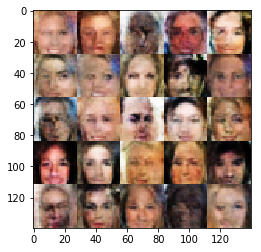

Iteration 6310 -- Epoch 1/1 -- Discriminator loss: 1.27852 -- Generator loss: 0.61723
Iteration 6320 -- Epoch 1/1 -- Discriminator loss: 1.30239 -- Generator loss: 0.61409
Iteration 6330 -- Epoch 1/1 -- Discriminator loss: 1.33538 -- Generator loss: 0.59888


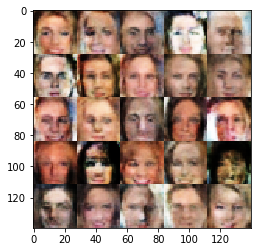

Done!


In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.